In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import matplotlib.animation as animation

from IPython.display import display, HTML

css = """
<style>
    .jp-Notebook .jp-Cell {
        margin-bottom: 16px !important;
    }
</style>
"""

display(HTML(css))

**Future Todo**

**First Question**:  

1. Mathematical Quantity to explain the divergence behaviour between revenue and sales / transaction during holiday season
2. Why there are peaks and troughs in revenue/sales/transactions per day plot
3. Mean being representation of data points and how standard deviation comes into play
4. Understand How can we compare between two groups with different samples size. This is one of the
   [video](https://youtu.be/OyB_w4XNQ58?feature=shared) i came across will seeing if welch's t test is good for
   comparing transaction number between November and December
5. Fully understand all the conclusion and why things in *November and December comparision* under second question
6. In revenue per day and transactions per day, where there such a drop and why there is spike. Examine them. Also
   look if weekends or weekdays driving most revenue.
7. AOV, revenue and trx per day: Why there is such spikes? and also understand moving average importance here

**Second Question**

1. Segment product into those three categories
2. I am not satisfied by just giving out the product names, is there a way to get information which can make money like focus on this product or something. Look in future
3. I don't think wholesale is really wholesale as one of the distinguishing feature is that unit price is cheap for them. research and find other factors which make wholesalers buyers wholesalers and till then will refer to as large purchases.

**Okay there is huge problem with small and large sales, which is if there are invoices with both mixed in then what?. Fuck let it be i will think about it later and if required will scrap and redo this analysis**

In [40]:
df = pd.read_excel("Online Retail.xlsx")

In [42]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


In [115]:
real_sales = df[(df["Quantity"] > 0) & (df["UnitPrice"] > 0)].copy(deep=True)
stock_series = real_sales["StockCode"]
stock_series = stock_series.astype(str)
real_sales = real_sales[stock_series.str.contains(r'\d', na=False)]
real_sales["TotalPrice"] = real_sales["Quantity"] * real_sales["UnitPrice"]
real_sales["YearMonth"] = real_sales["InvoiceDate"].dt.to_period("M")

"""
real_sales = df[~(df["UnitPrice"] < 0)]
stock_series = real_sales["StockCode"]
stock_series = stock_series.astype(str)
real_sales = real_sales[stock_series.str.contains(r'\d', na=False)]
"""

'\nreal_sales = df[~(df["UnitPrice"] < 0)]\nstock_series = real_sales["StockCode"]\nstock_series = stock_series.astype(str)\nreal_sales = real_sales[stock_series.str.contains(r\'\\d\', na=False)]\n'

In [6]:
small_sales = real_sales[real_sales["Quantity"] <= 24]
large_sales = real_sales[real_sales["Quantity"] > 24]

### CEO report

#### First Question: How the business is doing? Is it great or bad?

Showing increase in revenue, transactions and atv (but atv/aov seems stable look at last few cells)

##### Seeing graphs

***This is totally wrong, there are two segment, check below***
***Just comment on How the sales trends are and don't go into why they are such that***

To answer this, i will show revenue per month first which includes returns thus CEO would understand
how much money the company is making per month and what is trend of this making money per month. There is
also trend of revenue per day.

<img src="monthly_revenue.png" alt="Monthly Revenue" width="600"/>

Here we can see that after the drop the revenue is increasing steadily even though it is holiday season (cuz gift shop)
the end is higher than 2010-12 revenue. Thus marking growth in business. Here 2011-12 is lower due to dataset recording sales
for 9 days which is 2011-12-01 to 2011-12-09

But if we look at daily revenue, the last day marked the highest recorded revenue

<img src="daily_revenue.png" alt="Daily Revenue" width="600"/>

Again if we want to look at growth, let's look at daily total transaction (total unique invoices). Here it total
transaction is increased from values from troughs.

<img src="daily_trx.png" alt="Daily Transactions" width="600"/>

Lastly let's look at combined transactions, sales (total quantity) and revenue per day polynomial plot.

<img src="comparison.png" alt="Comparison" width="600"/>

Here towards the end, the revenue has more slope than sales, thus saying that customer are buying pricier products.
This can be shown in ATV (Average Transaction Value) which is increasing.

<img src="monthly_atv.png" alt="Monthly ATV" width="600"/>

Showing that average revenue per transaction is increasing.

##### Total revenue generated

In [5]:
# total revenue including business expense and returns

df["TotalPrice"] = df["Quantity"] * df["UnitPrice"]
print('${:,.2f}'.format(df["TotalPrice"].sum()))

$9,747,747.93


##### Per Day Trend

In [46]:
# real sales per day

# with returns and without business things only product being sold or returned
real_sales = df[(df["Quantity"] > 0) & (df["UnitPrice"] > 0)]

"""
real_sales = df[~(df["UnitPrice"] < 0)]
stock_series = real_sales["StockCode"]
stock_series = stock_series.astype(str)
real_sales = real_sales[stock_series.str.contains(r'\d', na=False)]
"""

summary = real_sales.groupby(df['InvoiceDate'].dt.date).agg(
    TotalTransactions=('InvoiceNo', 'nunique'),  # Count transactions
    TotalSales=('Quantity', 'sum'),          # Sum quantity sold
    TotalRevenue=('TotalPrice', 'sum')       # Sum total revenue
).reset_index()

summary['Days'] = summary['InvoiceDate'].apply(lambda x: x.toordinal())

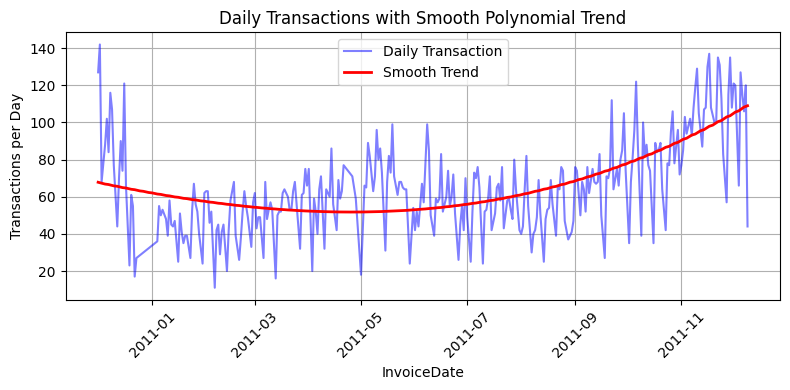

In [52]:
# plotting transaction per day

plt.figure(figsize=(8, 4))

# Fit a polynomial (e.g., degree 3 for a cubic polynomial)
degree = 3  # You can adjust the degree for more or less smoothness
trx_coef = np.polyfit(summary['Days'], summary['TotalTransactions'], degree)

# Create a smooth curve using the polynomial
smooth_days = np.linspace(summary['Days'].min(), summary['Days'].max(), 300)
smooth_trx = np.polyval(trx_coef, smooth_days)

# Convert smooth_days back to datetime for plotting
smooth_dates = [pd.Timestamp.fromordinal(int(day)) for day in smooth_days]

# Plot the original data
plt.plot(summary['InvoiceDate'], summary['TotalTransactions'], label='Daily Transaction', color='blue', alpha=0.5)

# Plot the smooth polynomial curve
plt.plot(smooth_dates, smooth_trx, label='Smooth Trend', color='red', linewidth=2)

# Add labels and legend
plt.xlabel("InvoiceDate")
plt.ylabel("Transactions per Day")
plt.title("Daily Transactions with Smooth Polynomial Trend")
plt.legend()
plt.grid(True)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Show the plot
plt.tight_layout()
plt.savefig("daily_trx.png")
plt.show()

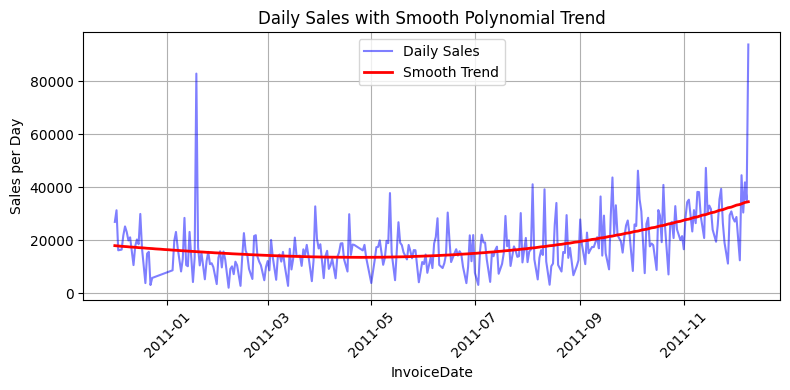

In [48]:
# plotting sales per day

plt.figure(figsize=(8, 4))

# Fit a polynomial (e.g., degree 3 for a cubic polynomial)
degree = 3  # You can adjust the degree for more or less smoothness
sales_coef = np.polyfit(summary['Days'], summary['TotalSales'], degree)

# Create a smooth curve using the polynomial
smooth_days = np.linspace(summary['Days'].min(), summary['Days'].max(), 300)
smooth_sales = np.polyval(sales_coef, smooth_days)

# Convert smooth_days back to datetime for plotting
smooth_dates = [pd.Timestamp.fromordinal(int(day)) for day in smooth_days]

# Plot the original data
plt.plot(summary['InvoiceDate'], summary['TotalSales'], label='Daily Sales', color='blue', alpha=0.5)

# Plot the smooth polynomial curve
plt.plot(smooth_dates, smooth_sales, label='Smooth Trend', color='red', linewidth=2)

# Add labels and legend
plt.xlabel("InvoiceDate")
plt.ylabel("Sales per Day")
plt.title("Daily Sales with Smooth Polynomial Trend")
plt.legend()
plt.grid(True)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Show the plot
plt.tight_layout()
plt.show()

**Note**: Above sales plot doesn't make sense as sales is total sales or quantity we sold not the returns we
are accounting. I will let it be, and leaving this note here for future me. But the revenue below and transaction
makes sense as we have to adjust number of returns and total money we have to return back to customer

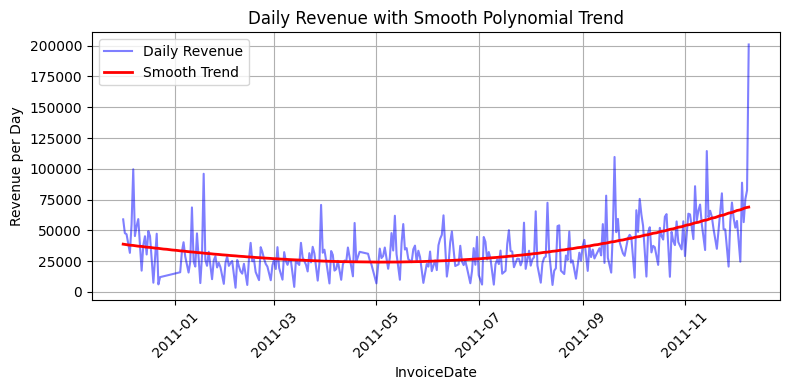

In [50]:
# plotting revenue per day

plt.figure(figsize=(8, 4))

# Fit a polynomial (e.g., degree 3 for a cubic polynomial)
degree = 3  # You can adjust the degree for more or less smoothness
revenue_coef = np.polyfit(summary['Days'], summary['TotalRevenue'], degree)

# Create a smooth curve using the polynomial
smooth_days = np.linspace(summary['Days'].min(), summary['Days'].max(), 300)
smooth_revenue = np.polyval(revenue_coef, smooth_days)

# Convert smooth_days back to datetime for plotting
smooth_dates = [pd.Timestamp.fromordinal(int(day)) for day in smooth_days]

# Plot the original data
"""
temp = np.linspace(summary['TotalRevenue'].min(), summary["TotalRevenue"].max(), 15)
xtemp = [pd.to_datetime("2011-06-14")] * 15
plt.plot(xtemp, temp, color="green")  # date when returns are highest. i.e., total quantity < 0
"""
plt.plot(summary['InvoiceDate'], summary['TotalRevenue'], label='Daily Revenue', color='blue', alpha=0.5)

# Plot the smooth polynomial curve
plt.plot(smooth_dates, smooth_revenue, label='Smooth Trend', color='red', linewidth=2)

# Add labels and legend
plt.xlabel("InvoiceDate")
plt.ylabel("Revenue per Day")
plt.title("Daily Revenue with Smooth Polynomial Trend")
plt.legend()
plt.grid(True)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Show the plot
plt.tight_layout()
plt.savefig("daily_revenue.png")
plt.show()

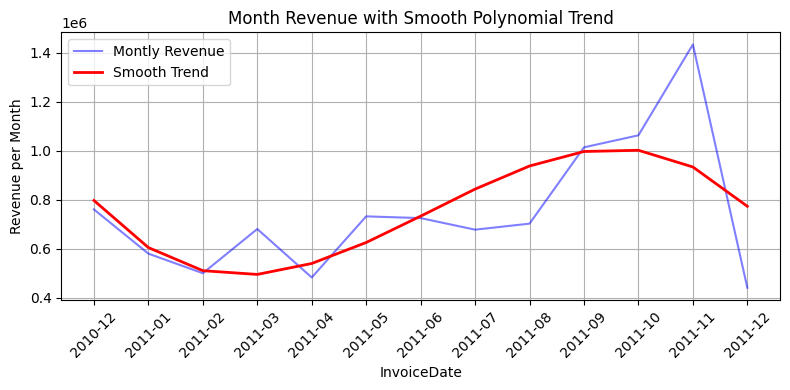

In [44]:
# plotting revenue per day

plt.figure(figsize=(8, 4))

monthlyrev = real_sales.groupby(real_sales["InvoiceDate"].dt.to_period('M'))["TotalPrice"].sum().reset_index()
monthlyrev["months"] = np.arange(monthlyrev["InvoiceDate"].size)

degree = 3
revenue_coef = np.polyfit(monthlyrev['months'], monthlyrev['TotalPrice'], degree)
smooth_revenue = np.polyval(revenue_coef, monthlyrev["months"])

plt.plot(monthlyrev['InvoiceDate'].apply(str), monthlyrev['TotalPrice'], label='Montly Revenue', color='blue', alpha=0.5)
plt.plot(monthlyrev['InvoiceDate'].apply(str), smooth_revenue, label='Smooth Trend', color='red', linewidth=2)

# Add labels and legend
plt.xlabel("InvoiceDate")
plt.ylabel("Revenue per Month")
plt.title("Month Revenue with Smooth Polynomial Trend")
plt.legend()
plt.grid(True)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Show the plot
plt.tight_layout()
plt.savefig("monthly_revenue.png")
plt.show()

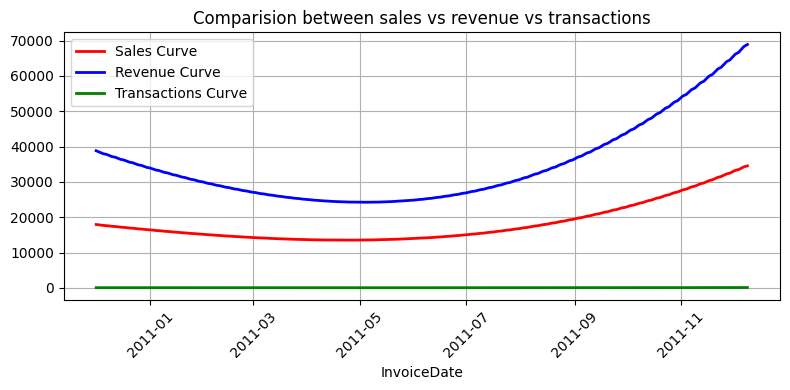

In [51]:
# comparing polynomial curvess

plt.figure(figsize=(8, 4))

plt.plot(smooth_dates, smooth_sales, label='Sales Curve', color='red', linewidth=2)
plt.plot(smooth_dates, smooth_revenue, label='Revenue Curve', color='blue', linewidth=2)
plt.plot(smooth_dates, smooth_trx, label='Transactions Curve', color='green', linewidth=2)

# Add labels and legend
plt.xlabel("InvoiceDate")
plt.title("Comparision between sales vs revenue vs transactions")
plt.legend()
plt.grid(True)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Show the plot
plt.tight_layout()
plt.savefig("comparison.png")
plt.show()

**Overal trend of curves**

- If the sales curve (blue) and revenue curve (red) follow a similar pattern (e.g., both increase or decrease at the same time), it suggests that sales and revenue are strongly correlated. This is common in retail, where higher sales directly lead to higher revenue.

- If the curves diverge significantly, it could indicate that revenue is not directly proportional to sales. This might happen due to:
  - Discounts or promotions: Higher sales volume but lower revenue due to reduced prices.
  - High-value items: Fewer sales but higher revenue due to expensive products.

But this is real_sales subset, so curves won't diverge. As said above about correlation.

**Peaks and Troughs**

- Peaks: If both curves peak at the same time, it indicates seasonal trends or successful marketing campaigns that boosted both sales and revenue.

- Troughs: If both curves dip simultaneously, it could indicate low-demand periods (e.g., holidays, off-seasons) or operational issues (e.g., stockouts).

Looking at above curve, during holiday season both sides are at peak indicating high transaction, sales and thus revenue. It lowers during the off season like summer one.

Also after `2011-07`, all the curves pick up but the revenue one has more slope or incline than other two. Indicating more
pricey stuff is being bought. To understand look at the delta r (revenue) and s (sales) for small time period. Here r > s, if s 
= 1 then r is like 2 or something. Which means having sold one product at price of 2x it's number. which is this overall product
is being priced at 2 something.

Same can be said for sales quantity and number of transaction.

**Divergent Behaviour**

*Future Todo*: Have a mathematical quantity which defines the above divergence when holiday season is coming

**Why those peaks and troughs**

*Future Todo*: Investigate what caused these peaks/troughs (e.g., promotions, holidays, stock issues).

In [76]:
# day when returns are more than sales

summary[summary["TotalSales"] == summary["TotalSales"].min()]

,InvoiceDate,TotalTransactions,TotalSales,TotalRevenue,Days
152,2011-06-14,1581,-13657,39953.82,734302


##### ATV (Average Transaction Value)

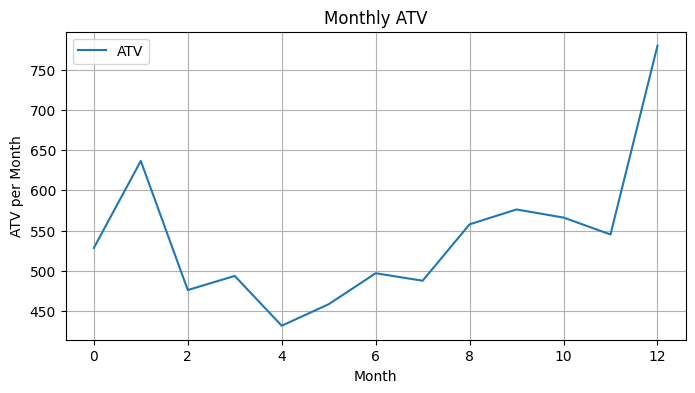

In [89]:
real_sales = df[(df["Quantity"] > 0) & (df["UnitPrice"] > 0)]
atv_data = real_sales.groupby(real_sales["InvoiceDate"].dt.to_period('M')).apply(
    lambda x: x["TotalPrice"].sum() / x["InvoiceNo"].nunique()
).reset_index(name="ATV")
atv_data.plot(kind='line', figsize=(8, 4))
plt.title('Monthly ATV')
plt.xlabel('Month')
plt.ylabel('ATV per Month')
plt.grid(True)
plt.show()

##### Growth Rate and segment in retail customer and wholesalers

In [7]:
# taking returns into account

real_sales = df[(df["Quantity"] > 0) & (df["UnitPrice"] > 0)].copy(deep=True)

"""
real_sales = df[~(df["UnitPrice"] < 0)]
stock_series = real_sales["StockCode"]
stock_series = stock_series.astype(str)
real_sales = real_sales[stock_series.str.contains(r'\d', na=False)]
"""

'\nreal_sales = df[~(df["UnitPrice"] < 0)]\nstock_series = real_sales["StockCode"]\nstock_series = stock_series.astype(str)\nreal_sales = real_sales[stock_series.str.contains(r\'\\d\', na=False)]\n'

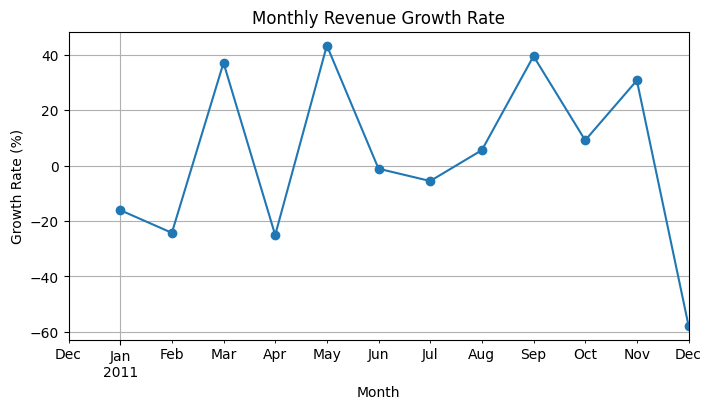

In [100]:
monthly_revenue = real_sales.groupby(df['InvoiceDate'].dt.to_period('M'))['TotalPrice'].sum()
revenue_growth_rate = monthly_revenue.pct_change() * 100

# Plot revenue growth rate
revenue_growth_rate.plot(kind='line', figsize=(8, 4), marker='o')
plt.title('Monthly Revenue Growth Rate')
plt.xlabel('Month')
plt.ylabel('Growth Rate (%)')
plt.grid(True)
plt.show()

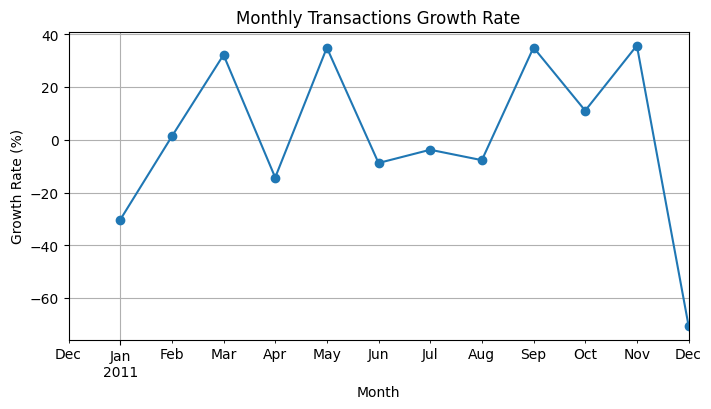

In [93]:
monthly_transactions = real_sales.groupby(df['InvoiceDate'].dt.to_period('M'))['InvoiceNo'].nunique()
transaction_growth_rate = monthly_transactions.pct_change() * 100

transaction_growth_rate.plot(kind='line', figsize=(8, 4), marker='o')
plt.title('Monthly Transactions Growth Rate')
plt.xlabel('Month')
plt.ylabel('Growth Rate (%)')
plt.grid(True)
plt.show()

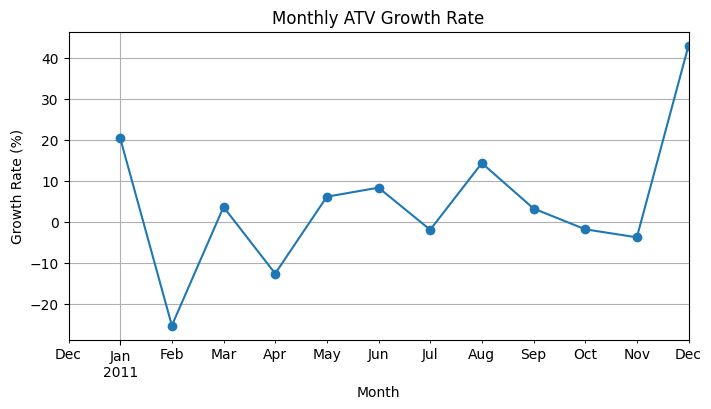

In [98]:
monthly_atv = real_sales.groupby(df['InvoiceDate'].dt.to_period('M')).apply(
    lambda x: x['TotalPrice'].sum() / x['InvoiceNo'].nunique()
)
atv_growth_rate = monthly_atv.pct_change() * 100

atv_growth_rate.plot(kind='line', figsize=(8, 4), marker='o')
plt.title('Monthly ATV Growth Rate')
plt.xlabel('Month')
plt.ylabel('Growth Rate (%)')
plt.grid(True)
plt.show()

In [101]:
revenue_growth_rate

InvoiceDate
2010-12          NaN
2011-01   -16.070677
2011-02   -24.261103
2011-03    37.050354
2011-04   -25.058650
2011-05    43.273274
2011-06    -1.141559
2011-07    -5.581788
2011-08     5.550057
2011-09    39.446272
2011-10     9.105424
2011-11    30.694665
2011-12   -57.681733
Freq: M, Name: TotalPrice, dtype: float64

In [96]:
transaction_growth_rate

InvoiceDate
2010-12          NaN
2011-01   -30.339962
2011-02     1.289134
2011-03    32.181818
2011-04   -14.305365
2011-05    34.911717
2011-06    -8.804283
2011-07    -3.783431
2011-08    -7.728814
2011-09    34.974284
2011-10    11.050626
2011-11    35.735294
2011-12   -70.422535
Freq: M, Name: InvoiceNo, dtype: float64

In [99]:
atv_growth_rate

InvoiceDate
2010-12          NaN
2011-01    20.484176
2011-02   -25.225053
2011-03     3.683212
2011-04   -12.548377
2011-05     6.197799
2011-06     8.402505
2011-07    -1.869072
2011-08    14.391135
2011-09     3.313215
2011-10    -1.751635
2011-11    -3.713573
2011-12    43.076044
Freq: M, dtype: float64

###### November and December revenue understanding

In [10]:
real_sales["YearMonth"] = real_sales["InvoiceDate"].dt.to_period("M")
november_data = real_sales[real_sales["YearMonth"] == pd.Period("2011-11", "M")]
december_data = real_sales[real_sales["YearMonth"] == pd.Period("2011-12", "M")]

In [11]:
november_data

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,YearMonth
431673,573744,21314,SMALL GLASS HEART TRINKET POT,8,2011-11-01 08:16:00,2.10,17733.0,United Kingdom,2011-11
431674,573744,21704,BAG 250g SWIRLY MARBLES,12,2011-11-01 08:16:00,0.85,17733.0,United Kingdom,2011-11
431675,573744,21791,VINTAGE HEADS AND TAILS CARD GAME,12,2011-11-01 08:16:00,1.25,17733.0,United Kingdom,2011-11
431676,573744,21892,TRADITIONAL WOODEN CATCH CUP GAME,12,2011-11-01 08:16:00,1.25,17733.0,United Kingdom,2011-11
431677,573744,21915,RED HARMONICA IN BOX,12,2011-11-01 08:16:00,1.25,17733.0,United Kingdom,2011-11
...,...,...,...,...,...,...,...,...,...
516364,579885,85034C,3 ROSE MORRIS BOXED CANDLES,4,2011-11-30 17:37:00,1.25,15444.0,United Kingdom,2011-11
516365,579885,21742,LARGE ROUND WICKER PLATTER,2,2011-11-30 17:37:00,5.95,15444.0,United Kingdom,2011-11
516366,579885,23084,RABBIT NIGHT LIGHT,6,2011-11-30 17:37:00,2.08,15444.0,United Kingdom,2011-11
516367,579885,21257,VICTORIAN SEWING BOX MEDIUM,1,2011-11-30 17:37:00,7.95,15444.0,United Kingdom,2011-11


###### Transaction Data

In [20]:
nov_trx = november_data.groupby(november_data["InvoiceDate"].dt.date)["InvoiceNo"].nunique()

In [21]:
dec_trx = december_data.groupby(december_data["InvoiceDate"].dt.date)["InvoiceNo"].nunique()

In [23]:
nov_trx.std(), dec_trx.std()

(np.float64(19.66367208839692), np.float64(30.420564003412466))

With above values i can't compare mean of both of them to arrive at conclusion that transaction in december
is more than transaction in november month. The reason being std represent spread from mean value and since
we are comparing relation with mean, the mean might not necessarily be good representation of entire series.

For example:
If they both had mean like 10 and 15 and std like 2 or 3. Since std are similar and low thus 10 and 15 are
good representation of entire series dataset. Thus i can confidently say that december has higher transaction.

But i still can't make sense of it, as i am being abstract here. Also the case where std values of both are
similar but large, then what?

*Todo*: Look into above thing

For now let's look at the things recommended by chatgpt

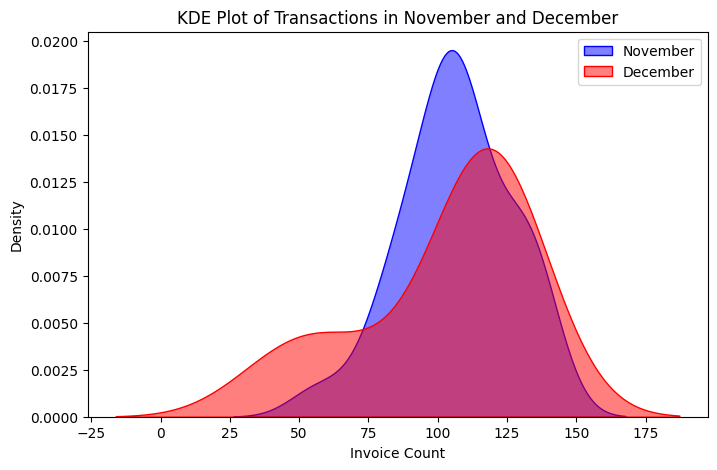

In [34]:
# let's look at kde plots

plt.figure(figsize=(8, 5))

sns.kdeplot(nov_trx, label="November", fill=True, color='blue', alpha=0.5)
sns.kdeplot(dec_trx, label="December", fill=True, color='red', alpha=0.5)

plt.xlabel("Invoice Count")
plt.ylabel("Density")
plt.title("KDE Plot of Transactions in November and December")

plt.legend()

plt.savefig("kde.png")
plt.show()

The KDE plot **visually confirms** what the standard deviation hinted at—December's transaction values are much more **spread out**, while November's are **tightly concentrated**.  

**Why Does This Solidify Our Concern About the Mean?**  
- The **mean assumes a balanced, symmetrical distribution** where most values are close to the center.  
- But in December, we see **wide fluctuations**, meaning the mean could be **misleading** because:  
  - Some days had **very low transactions (~50)**, dragging the mean down.  
  - Some days had **high transactions (~120-130)**, pushing the mean up.  
  - This mix of low and high values makes the mean unstable.  

So, yes—this KDE plot **justifies why the mean isn’t a good representative!**

**Now, How Can Welch’s t-test Help?**  
Since we know the mean is shaky, Welch’s t-test will **mathematically quantify how unreliable** the mean difference is.  

**What it does:**  
- It tests **whether the difference in means is statistically significant** or if it's just random fluctuation.  
- It accounts for **unequal variances and different sample sizes** (which we have).  
- If the **p-value > 0.05**, the difference in means **isn’t significant**, proving our point that the mean is unreliable!  

In [35]:
from scipy.stats import ttest_ind

# Perform Welch's t-test (equal_var=False accounts for different variances)
t_stat, p_value = ttest_ind(nov_trx, dec_trx, equal_var=False)

# Print results
print(f"T-statistic: {t_stat:.4f}")
print(f"P-value: {p_value:.4f}")

# Interpretation
if p_value < 0.05:
    print("🔴 The difference in means is statistically significant. (Reject H0)")
else:
    print("🟢 The difference in means is NOT statistically significant. (Fail to reject H0)")

T-statistic: 0.3610
P-value: 0.7265
🟢 The difference in means is NOT statistically significant. (Fail to reject H0)


**Does This Mean Our Initial Assumption About the Mean Was Wrong?**  

**No, our assumption is still correct!**  
The Welch’s t-test **does not test whether the mean is a good representative**. Instead, it **tests whether the two means are significantly different** from each other.  

**What Does This Test Actually Do?**  
- **Null Hypothesis (H₀)**: The means of November and December are the **same**.  
- **Alternative Hypothesis (H₁)**: The means of November and December are **different**.  

Your **p-value = 0.7265**, which is very high (>0.05). This means:  
✅ The test **found no significant difference** between the two means.  
✅ It suggests that the small difference in means **could just be random chance**.  

**Does This Mean the Mean is Reliable?**  

**No, because the test doesn’t measure that!** The test only tells us that the means aren’t significantly different.  

We still know:  
1. **December has higher variability (std = 30.42 vs. 19.66)**.  
2. **December’s data is more spread out (confirmed by KDE plot)**.  
3. **Mean doesn’t represent December well** because of its inconsistent spread.  

So, while the means aren’t statistically different, **the high standard deviation still makes the mean unreliable as a summary statistic for December**.

**Final Takeaway 🚀**  

- **Welch’s t-test shows the two means are not significantly different.**  
- **But it does NOT mean the mean is a good representative!**  
- **Given high variability, median or another robust metric is still better.**  

In [39]:
# let's look at another representative for two groups

from scipy.stats import mannwhitneyu

median_nov = np.median(nov_trx)
median_dec = np.median(dec_trx)

print(f"Median (November): {median_nov}")
print(f"Median (December): {median_dec}")

q1_nov, q3_nov = np.percentile(nov_trx, [25, 75])
iqr_nov = q3_nov - q1_nov

q1_dec, q3_dec = np.percentile(dec_trx, [25, 75])
iqr_dec = q3_dec - q1_dec

print(f"IQR (November): {iqr_nov}")
print(f"IQR (December): {iqr_dec}")

# Perform Mann-Whitney U test
u_stat, p_value = mannwhitneyu(nov_trx, dec_trx, alternative='two-sided')

print(f"Mann-Whitney U statistic: {u_stat}")
print(f"P-value: {p_value}")

if p_value < 0.05:
    print("🔴 The distributions are significantly different. (Reject H0)")
else:
    print("🟢 No significant difference in distributions. (Fail to reject H0)")


Median (November): 107.5
Median (December): 117.5
IQR (November): 22.5
IQR (December): 24.25
Mann-Whitney U statistic: 96.5
P-value: 0.7760243798118613
🟢 No significant difference in distributions. (Fail to reject H0)


**1️⃣ Median Comparison (More Reliable Than Mean)**

- **November Median = 107.5**  
- **December Median = 117.5**  
✅ **December’s median is higher**, suggesting that transactions **might** have increased.  
❌ **But the difference is small (only +10 invoices), so it’s not a strong increase.**  

**2️⃣ IQR (Variability of Transactions)**

- **November IQR = 22.5**  
- **December IQR = 24.25**  
✅ December has a **slightly wider spread**, but the difference is small.  
❌ This means **December’s transactions were not much more variable** than November’s.  

**3️⃣ Mann-Whitney U Test (Statistical Significance)**

- **U statistic = 96.5**  
- **P-value = 0.776** (way above 0.05)  
🟢 **Since p-value > 0.05, we fail to reject H₀ (no significant difference).**  
❌ This confirms that **the slight median difference is not statistically meaningful**—it could just be random variation.  

**🚀 Final Conclusion**
1. **December’s median is slightly higher (+10 invoices), but the difference is too small to be meaningful.**  
2. **The transaction variability (IQR) is almost the same, meaning fluctuation patterns were similar.**  
3. **The Mann-Whitney U test confirms that there is NO statistically significant difference.**  

**👉 Verdict:** There is **no strong evidence** that transactions increased in December compared to November. The slight median increase is **not enough** to conclude a meaningful rise.  

###### AOV (Average Order Value)

In [56]:
nov_aov = november_data.groupby('InvoiceNo')[["Quantity", "UnitPrice"]].apply(lambda x: (x['Quantity'] * x['UnitPrice']).sum())
dec_aov = december_data.groupby('InvoiceNo')[["Quantity", "UnitPrice"]].apply(lambda x: (x['Quantity'] * x['UnitPrice']).sum())

In [63]:
print(f"November Mean: {nov_aov.mean()} and Std: {nov_aov.std()}")
print(f"December Mean: {dec_aov.mean()} and Std: {dec_aov.std()}")

November Mean: 545.1413253882268 and Std: 1654.4874520313547
December Mean: 779.9666422466424 and Std: 5992.582128615431


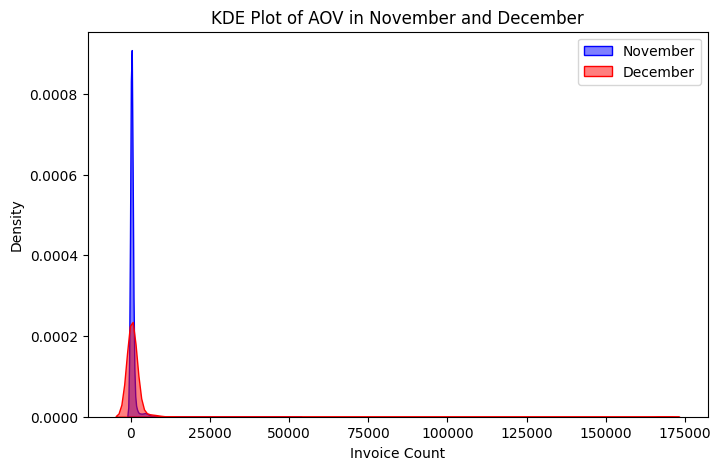

In [62]:
# looking at kdeplot

plt.figure(figsize=(8, 5))

sns.kdeplot(nov_aov, label="November", fill=True, color='blue', alpha=0.5)
sns.kdeplot(dec_aov, label="December", fill=True, color='red', alpha=0.5)

plt.xlabel("Invoice Count")
plt.ylabel("Density")
plt.title("KDE Plot of AOV in November and December")

plt.legend()

plt.savefig("kde.png")
plt.show()

The standard deviation (std) is huge for both months, but December’s is much larger (5992 vs. 1654).  
BUT the KDE plot doesn’t show that extreme spread, meaning a few extreme outliers are inflating the standard deviation.

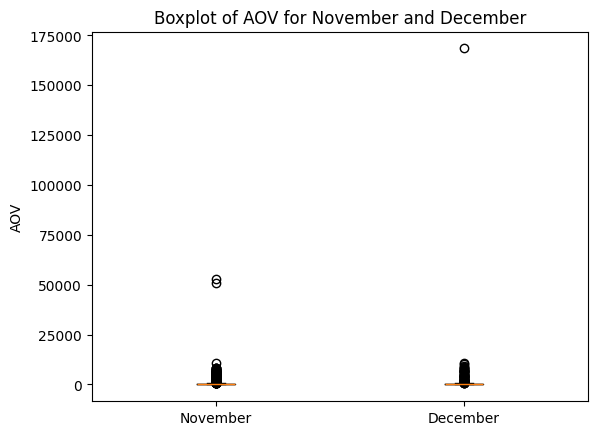

November 95th percentile: 1507.5099999999986
December 95th percentile: 1852.895
Number of rows having value more than 95 percentile 41


In [74]:
# let's check if there are extremes values in december that's why it's std is high

# Boxplot to visualize outliers
plt.boxplot([nov_aov, dec_aov], tick_labels=['November', 'December'])
plt.title("Boxplot of AOV for November and December")
plt.ylabel("AOV")
plt.show()

# Check top 5% values
print("November 95th percentile:", np.percentile(nov_aov, 95))
print("December 95th percentile:", np.percentile(dec_aov, 95))

# looking at how many this values
print("Number of rows having value more than 95 percentile", dec_aov[dec_aov >= np.percentile(dec_aov, 95)].size)

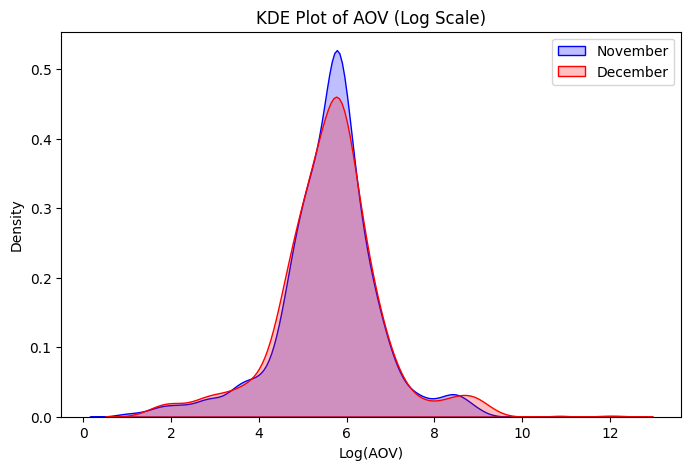

In [76]:
# so yeah that outlier is streching the value and thus it is also affecting the value of mean
# to see the difference very well let's use log scale and plot kde plot

plt.figure(figsize=(8,5))
sns.kdeplot(np.log1p(nov_aov), color='blue', label='November', fill=True)
sns.kdeplot(np.log1p(dec_aov), color='red', label='December', fill=True)
plt.xlabel("Log(AOV)")
plt.title("KDE Plot of AOV (Log Scale)")
plt.legend()
plt.show()

**What Log Scale Does in KDE:**

- **Brings extreme values closer to the main peaks**, so they don’t distort the overall shape.  
- **Preserves the overall structure** of the data while preventing a few large values from dominating the visualization.  
- **Makes the peaks (main transaction values) more visible**, instead of being overshadowed by outliers.  
- **Keeps outliers separate**, so you can still see that they exist without them ruining the scale.  

Now, instead of looking at a **skewed KDE where most values seem squished**, you get a **balanced view** of how AOV is actually distributed!

Looking at above KDE, there AOV value are about same. Let's look at median value of both group

In [78]:
# yeah meadian value is about the same. So there is no change in AOV value

median_nov = np.median(nov_aov)
median_dec = np.median(dec_aov)

print(f"Median (November): {median_nov}")
print(f"Median (December): {median_dec}")

Median (November): 300.6
Median (December): 300.54


Since AOV and transaction values are about same, this means that revenue should not increase

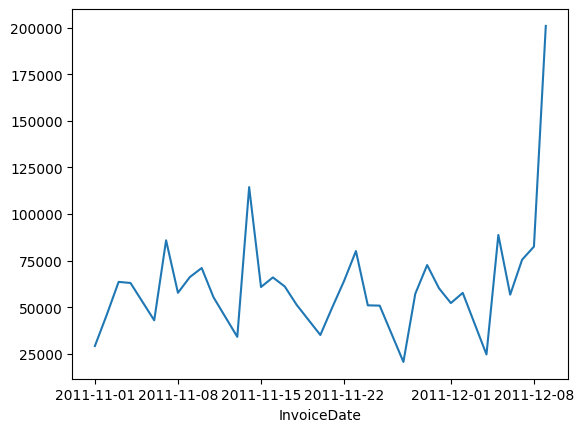

In [128]:
k = real_sales[real_sales["InvoiceDate"].dt.to_period("M") >= pd.Period("2011-11", "M")].copy(deep=True)
k["TotalPrice"] = k["Quantity"] * k["UnitPrice"]
k.groupby(k["InvoiceDate"].dt.date)["TotalPrice"].sum().plot()
plt.show()

###### Understanding why 9th december 2011 has highest recorded revenue

In [131]:
k.groupby(k["InvoiceDate"].dt.date)["TotalPrice"].sum().iloc[-2:]

InvoiceDate
2011-12-08     82495.0
2011-12-09    200920.6
Name: TotalPrice, dtype: float64

In [108]:
dec8 = k[k["InvoiceDate"].dt.date == pd.to_datetime("2011-12-08").date()]
dec9 = k[k["InvoiceDate"].dt.date == pd.to_datetime("2011-12-09").date()]

In [114]:
# comparing transaction values

print(f"December 8th transaction amt: {dec8['InvoiceNo'].nunique()}")
print(f"December 9th transaction amt: {dec9['InvoiceNo'].nunique()}")

December 8th transaction amt: 120
December 9th transaction amt: 44


***These are not AOV but order per invoice***

In [116]:
# comparing AOV values

dec8aov = dec8.groupby("InvoiceNo")["TotalPrice"].sum()
dec9aov = dec9.groupby("InvoiceNo")["TotalPrice"].sum()

print(f"8th Mean: {dec8aov.mean()} and Std: {dec8aov.std()}")
print(f"9th Mean: {dec9aov.mean()} and Std: {dec9aov.std()}")

8th Mean: 687.4583333333334 and Std: 1574.650664621254
9th Mean: 4566.3772727272735 and Std: 25325.727252581062


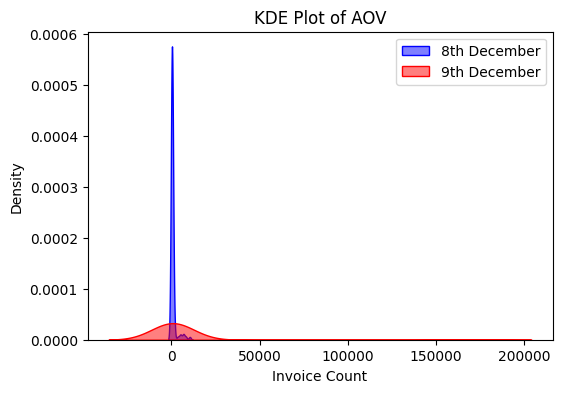

In [136]:
# looking at kdeplot

plt.figure(figsize=(6, 4))

sns.kdeplot(dec8aov.values, label="8th December", fill=True, color='blue', alpha=0.5)
sns.kdeplot(dec9aov.values, label="9th December", fill=True, color='red', alpha=0.5)

plt.xlabel("Invoice Count")
plt.ylabel("Density")
plt.title("KDE Plot of AOV")

plt.legend()
plt.show()

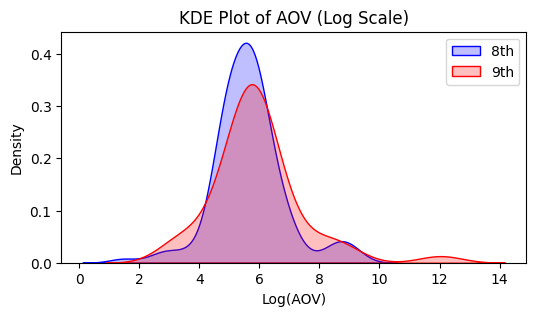

In [133]:
plt.figure(figsize=(6,3))
sns.kdeplot(np.log1p(dec8aov), color='blue', label='8th', fill=True)
sns.kdeplot(np.log1p(dec9aov), color='red', label='9th', fill=True)
plt.xlabel("Log(AOV)")
plt.title("KDE Plot of AOV (Log Scale)")
plt.legend()
plt.savefig("kde.png")
plt.show()

Since transaction is not higher in 9th december so i thought that due to high AOV, the revenue is highest.
But looking at above log scale KDE, the majority orders have same order per invoice (not aov as we didn't calculate mean).
Note that KDE plot show the peaks as those values having repeated more times. So majority of transaction in both 
the date have similar AOV, so similar revenue.

Thus it leads to think that, due to outlier order per invoice in 9th december. The revenue becomes the highest.

In [138]:
np.percentile(dec8aov, 95), np.percentile(dec9aov, 95)

(np.float64(3661.4009999999967), np.float64(5297.736500000003))

In [143]:
# so invoice No 581483 is having huge outlier

dec9aov[dec9aov >= np.percentile(dec9aov, 80)]

InvoiceNo
581476      2618.89
581483    168469.60
581485       741.90
581492      7689.23
581495      1203.90
581497      3217.20
581498      5664.89
581578       848.55
581579       903.62
Name: TotalPrice, dtype: float64

In [150]:
m = dec9aov.sum() - dec9aov[581483]
print(f"Original Revenue: {dec9aov.sum()}")
print(f"Subtracted Revenue: {m}")
print(f"Percentage Dropped Revenue: {(1 - (m / dec9aov.sum())) * 100}")

Original Revenue: 200920.60000000003
Subtracted Revenue: 32451.00000000003
Percentage Dropped Revenue: 83.84884377211694


- 83.85% of the revenue on December 9th came from just one extreme transaction.
- Without that one high-value order, revenue drops from 200,920 to just 32,451.
- This means the overall business activity (transactions & typical order values) was NOT drastically different—it was just one huge order inflating the numbers.

In [151]:
# looking at the invoice

k[k["InvoiceNo"] == 581483]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,YearMonth,TotalPrice
540421,581483,23843,"PAPER CRAFT , LITTLE BIRDIE",80995,2011-12-09 09:15:00,2.08,16446.0,United Kingdom,2011-12,168469.6


Let's look at revenue per day from lens of median

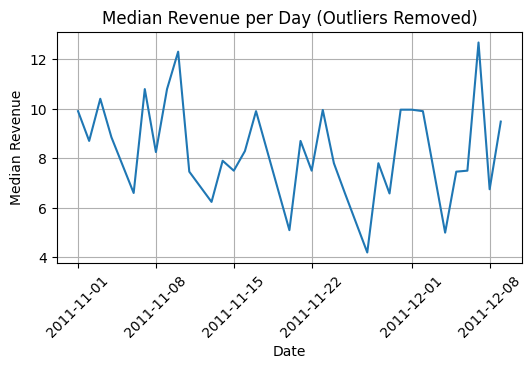

In [159]:
real_sales["TotalPrice"] = real_sales["Quantity"] * real_sales["UnitPrice"]
daily_median_revenue = real_sales[real_sales["InvoiceDate"].dt.date >= pd.to_datetime("2011-11-01").date()].groupby(df['InvoiceDate'].dt.date)['TotalPrice'].median()

plt.figure(figsize=(6,3))
plt.plot(daily_median_revenue.index, daily_median_revenue.values, linestyle='-')
plt.xlabel("Date")
plt.ylabel("Median Revenue")
plt.title("Median Revenue per Day (Outliers Removed)")
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.grid()
plt.show()

###### Understand Outliers

In [4]:
# let's first understand what bulk orders are, how are they different from normal order
# in what sense is it day wise or month wise or general
# understand frequency of bulk order to understand if we should add them to overall revenue
# calculation or can i remove it
# i need confidence about those orders

In [5]:
df["TotalPrice"] = df["Quantity"] * df["UnitPrice"]

real_sales = df[(df["Quantity"] > 0) & (df["UnitPrice"] > 0)]
stock_series = real_sales["StockCode"].astype(str)
real_sales = real_sales[stock_series.str.contains(r'\d', na=False)]

In [6]:
totalprice = real_sales.sort_values(by="TotalPrice", ascending=False)["TotalPrice"]

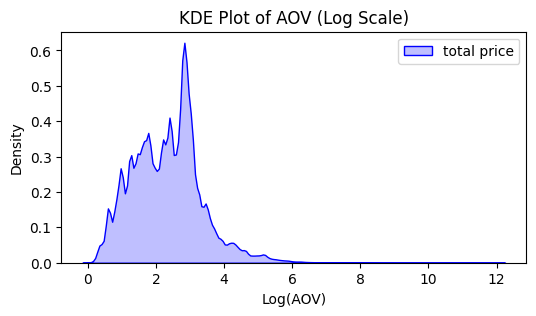

In [19]:
plt.figure(figsize=(6,3))
sns.kdeplot(np.log1p(totalprice), color='blue', label='total price', fill=True)
plt.xlabel("Log(AOV)")
plt.title("KDE Plot of AOV (Log Scale)")
plt.legend()
plt.show()

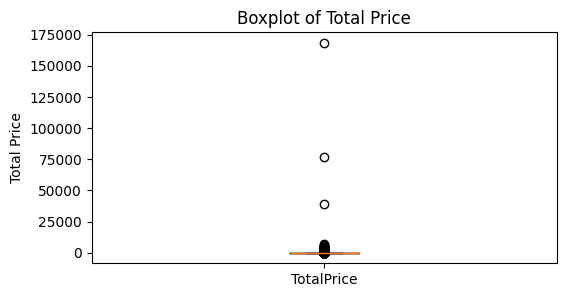

In [23]:
plt.figure(figsize=(6,3))
plt.boxplot([totalprice], tick_labels=['TotalPrice'])
plt.title("Boxplot of Total Price")
plt.ylabel("Total Price")
plt.show()

In [29]:
np.percentile(totalprice, 99)

np.float64(179.0)

In [33]:
# these are wholesaler as i suppose cause they are requesting huge quantity
# I will keep those values because they are part of business and will study them in customer
# section about those who are seller or retail customer
real_sales.sort_values(by="TotalPrice", ascending=False).head(40)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice
540421,581483,23843,"PAPER CRAFT , LITTLE BIRDIE",80995,2011-12-09 09:15:00,2.08,16446.0,United Kingdom,168469.60
61619,541431,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215,2011-01-18 10:01:00,1.04,12346.0,United Kingdom,77183.60
222680,556444,22502,PICNIC BASKET WICKER 60 PIECES,60,2011-06-10 15:28:00,649.50,15098.0,United Kingdom,38970.00
348325,567423,23243,SET OF TEA COFFEE SUGAR TINS PANTRY,1412,2011-09-20 11:05:00,5.06,17450.0,United Kingdom,7144.72
160546,550461,21108,FAIRY CAKE FLANNEL ASSORTED COLOUR,3114,2011-04-18 13:20:00,2.10,15749.0,United Kingdom,6539.40
52711,540815,21108,FAIRY CAKE FLANNEL ASSORTED COLOUR,3114,2011-01-11 12:55:00,2.10,15749.0,United Kingdom,6539.40
421601,573003,23084,RABBIT NIGHT LIGHT,2400,2011-10-27 12:11:00,2.08,14646.0,Netherlands,4992.00
52709,540815,85123A,WHITE HANGING HEART T-LIGHT HOLDER,1930,2011-01-11 12:55:00,2.55,15749.0,United Kingdom,4921.50
467804,576365,22086,PAPER CHAIN KIT 50'S CHRISTMAS,688,2011-11-14 17:55:00,6.95,NaN,United Kingdom,4781.60
160542,550461,85123A,WHITE HANGING HEART T-LIGHT HOLDER,1930,2011-04-18 13:20:00,2.40,15749.0,United Kingdom,4632.00


In [34]:
# Analysis with outliers
with_outliers = real_sales['TotalPrice'].sum()

# Analysis without outliers
without_outliers = real_sales[real_sales['TotalPrice'] < real_sales['TotalPrice'].quantile(0.99)]['TotalPrice'].sum()

print(f"Total Revenue With Outliers: {with_outliers}")
print(f"Total Revenue Without Outliers: {without_outliers}")

Total Revenue With Outliers: 10278874.89
Total Revenue Without Outliers: 7706364.86


If the high TotalSpend transactions are from retail sellers (e.g., bulk purchases of low-unit-price products), they are likely legitimate business transactions rather than outliers or errors. In this case, removing them would distort your analysis because they represent a significant portion of your revenue and are part of your business model.

Now to segment those, i need to create a threshold of number of quantity. Let's look at Quantity data and create
a threshold

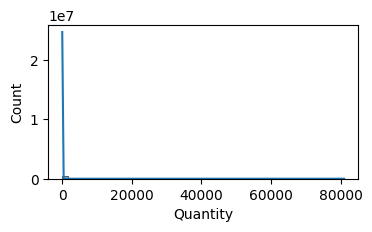

In [38]:
# let's look at histplot

plt.figure(figsize=(4, 2))
sns.histplot(real_sales["Quantity"], bins=50, kde=True)
plt.show()

In [39]:
# above value is shit cause of outlier gap

real_sales["Quantity"].sort_values(ascending=False)

540421    80995
61619     74215
421632     4800
206121     4300
97432      3906
          ...  
360726        1
360729        1
360730        1
360731        1
372764        1
Name: Quantity, Length: 527906, dtype: int64

In [61]:
print(f"90th percentile quantity: {real_sales['Quantity'].quantile(0.90)}")
print(f"95th percentile quantity: {real_sales['Quantity'].quantile(0.95)}")
print(f"99th percentile quantity: {real_sales['Quantity'].quantile(0.99)}")

90th percentile quantity: 24.0
95th percentile quantity: 30.0
99th percentile quantity: 100.0


In [7]:
wholesalers = real_sales[real_sales['Quantity'] > 24].shape[0]
retailers = real_sales[real_sales['Quantity'] <= 24].shape[0]
ratio = retailers / wholesalers
print(f"Retail: {retailers}, Wholesalers: {wholesalers}, Ratio: {ratio}")

Retail: 495577, Wholesalers: 32329, Ratio: 15.32917813727613


###### Sales performance of retail customer

In [63]:
# Let use Quantity = 24 as threshold as i can't find others criteria to separate
# then let's look at revenue per day data in retail customer and wholeseller

In [9]:
retailers = real_sales[real_sales["Quantity"] <= 24]
wholesalers = real_sales[real_sales["Quantity"] > 24]

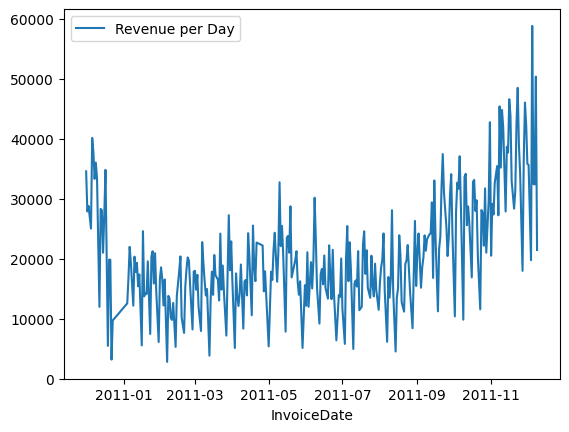

In [73]:
retailers.groupby(retailers["InvoiceDate"].dt.date)["TotalPrice"].sum().plot(label="Revenue per Day")
plt.savefig("retailers.png")
plt.legend()
plt.show()

1. High Variability in Revenue

The daily revenue is highly volatile, with significant fluctuations over time.
There are sharp peaks and drops, indicating inconsistent purchasing behavior.

2. Seasonality or External Factors?

The upward trend towards the end of the year suggests seasonal demand (e.g., holiday shopping in Q4).
The low points might be weekends, holidays, or low-sales periods.

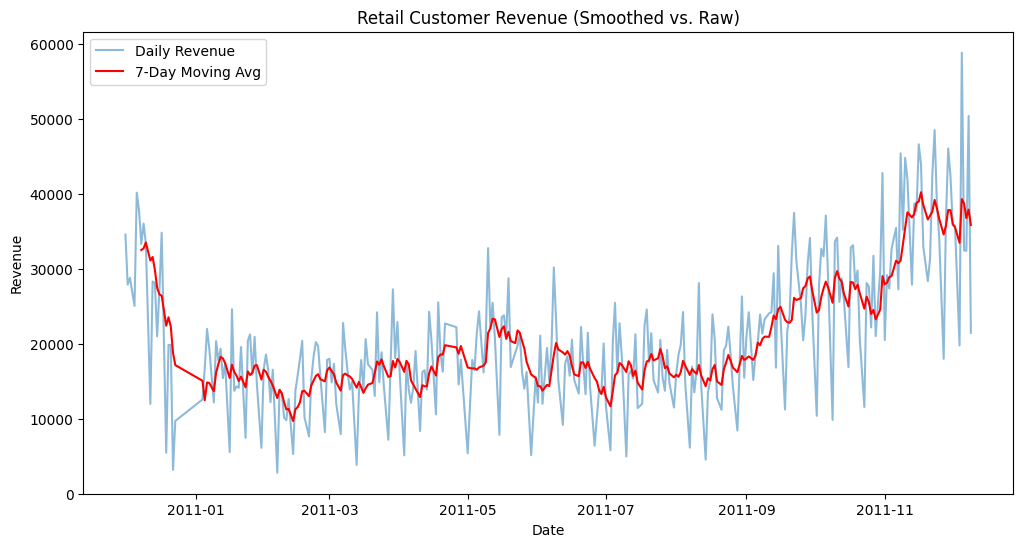

In [10]:
retail_revenue = retailers.groupby(retailers["InvoiceDate"].dt.date)["TotalPrice"].sum()
revenue_smooth = retail_revenue.rolling(window=7).mean()  # 7-day MA

# Plot original vs. smoothed
plt.figure(figsize=(12,6))
plt.plot(retail_revenue.index, retail_revenue, alpha=0.5, label='Daily Revenue')  # Original
plt.plot(revenue_smooth.index, revenue_smooth, color='red', label='7-Day Moving Avg')  # Smoothed
plt.legend()
plt.xlabel("Date")
plt.ylabel("Revenue")
plt.title("Retail Customer Revenue (Smoothed vs. Raw)")
plt.show()

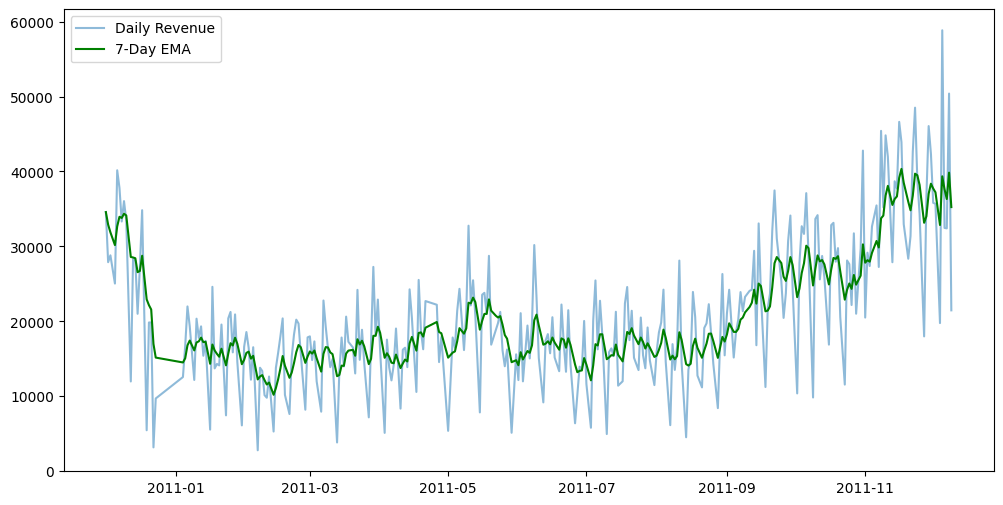

In [16]:
revenue_ema = retail_revenue.ewm(span=7, adjust=False).mean()

plt.figure(figsize=(12,6))
plt.plot(retail_revenue.index, retail_revenue, alpha=0.5, label='Daily Revenue')  # Original
plt.plot(revenue_ema.index, revenue_ema, color='green', label='7-Day EMA')  # Smoothed
plt.legend()
plt.show()

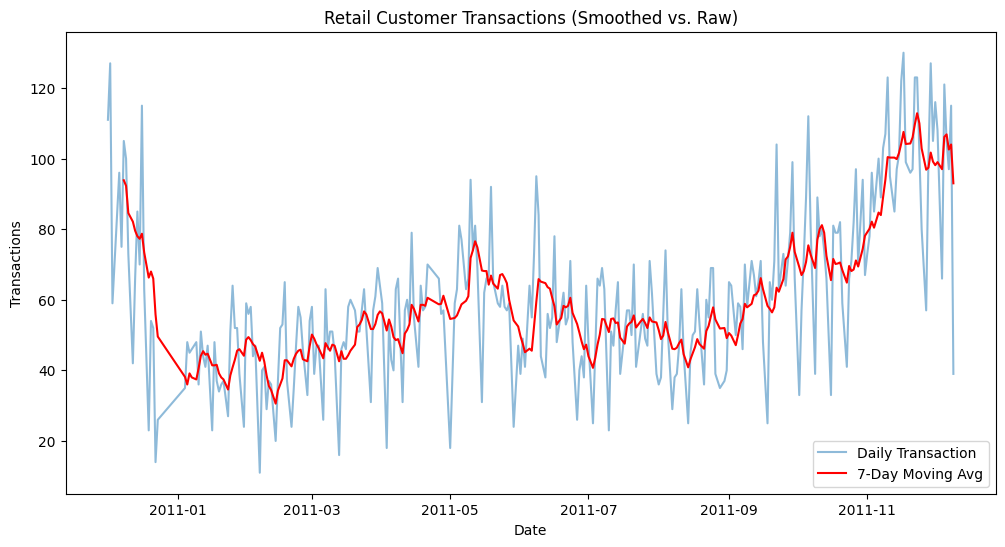

In [12]:
# lets look at trx data

retail_trx = retailers.groupby(retailers["InvoiceDate"].dt.date)["InvoiceNo"].nunique()
trx_smooth = retail_trx.rolling(window=7).mean()  # 7-day MA

# Plot original vs. smoothed
plt.figure(figsize=(12,6))
plt.plot(retail_trx.index, retail_trx, alpha=0.5, label='Daily Transaction')  # Original
plt.plot(trx_smooth.index, trx_smooth, color='red', label='7-Day Moving Avg')  # Smoothed
plt.legend()
plt.xlabel("Date")
plt.ylabel("Transactions")
plt.title("Retail Customer Transactions (Smoothed vs. Raw)")
plt.show()

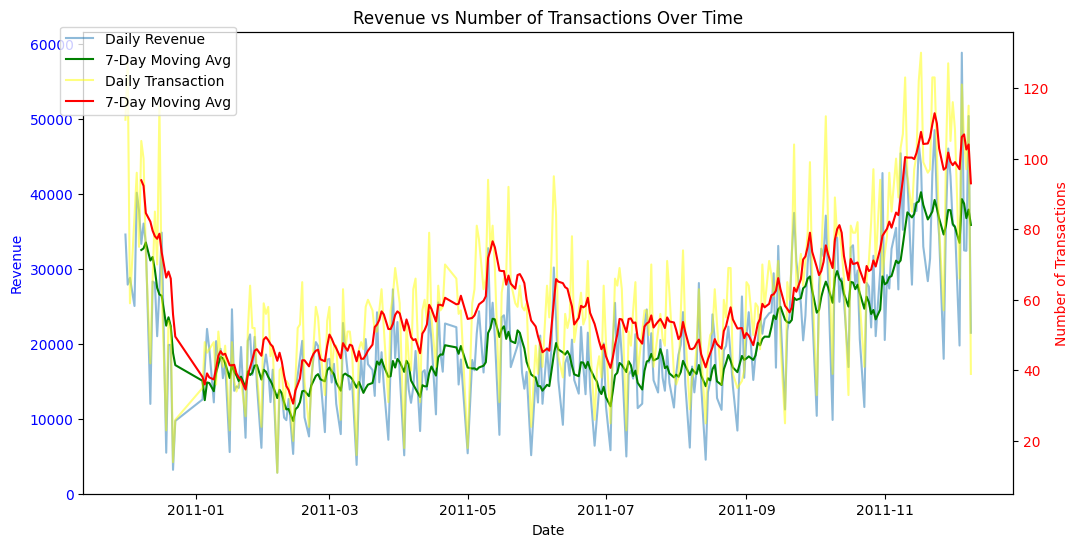

In [23]:
# lets superimpose revenue and transactions

fig, ax1 = plt.subplots(figsize=(12,6))

# Plot Revenue on Primary Y-Axis
ax1.plot(retail_revenue.index, retail_revenue, alpha=0.5, label='Daily Revenue')  # Original
ax1.plot(revenue_smooth.index, revenue_smooth, color='green', label='7-Day Moving Avg')  # Smoothed
ax1.set_xlabel("Date")
ax1.set_ylabel("Revenue", color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Create Secondary Y-Axis for Transactions
ax2 = ax1.twinx()
ax2.plot(retail_trx.index, retail_trx, color='yellow', alpha=0.5, label='Daily Transaction')  # Original
ax2.plot(trx_smooth.index, trx_smooth, color='red', label='7-Day Moving Avg')  # Smoothed
ax2.set_ylabel("Number of Transactions", color='red')
ax2.tick_params(axis='y', labelcolor='red')

# Add legends
fig.legend(loc='upper left', bbox_to_anchor=(0.1,0.9))
plt.title("Revenue vs Number of Transactions Over Time")
plt.savefig("rev_trans.png")
plt.show()

Key Insights from the Graph

1. Revenue and Number of Transactions are Positively Correlated

As the number of transactions increases, revenue also increases.
This suggests that higher customer activity directly drives revenue growth.

2. Seasonality & Trend

Both revenue and transactions show a general upward trend, especially towards the end of the year.
There might be seasonal effects (e.g., promotions, holiday sales) influencing both metrics.

3. Short-Term Fluctuations Exist

While the moving averages (green & red lines) show clear trends, the daily data (blue & yellow lines) have spikes and dips.
These fluctuations could be due to weekends, holidays, or specific marketing events.

Next Steps for Deeper Analysis

Check if Average Order Value (Revenue per Transaction) is stable or fluctuates over time.  
Look at day-of-the-week trends—are weekends or weekdays driving most revenue?  
Identify any anomalies (spikes or drops) to see what external factors influence revenue.

This graph is solid proof that transaction volume is a key driver of revenue growth!

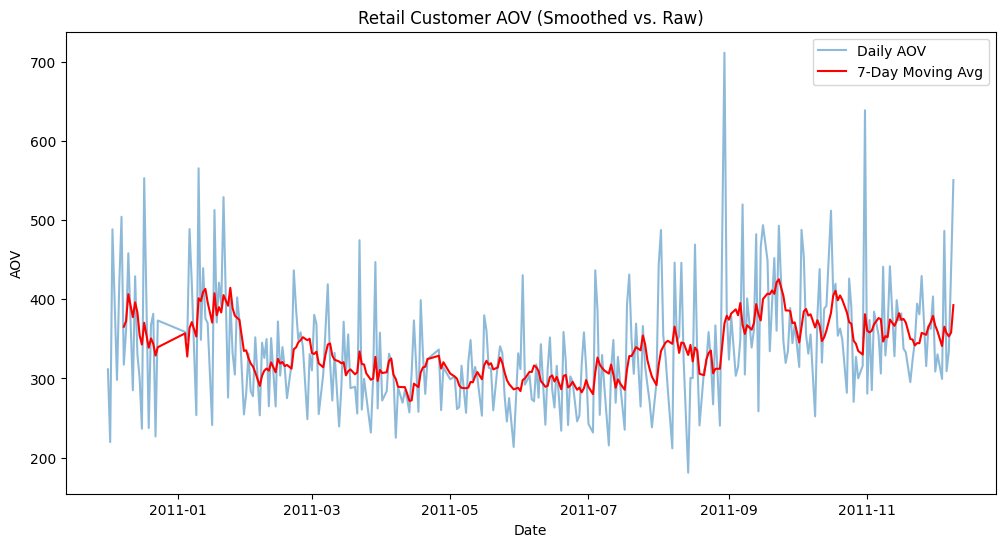

In [26]:
retail_aov = retailers.groupby(retailers["InvoiceDate"].dt.date)[["InvoiceNo", "TotalPrice"]].apply(
    lambda x: x["TotalPrice"].sum() / x["InvoiceNo"].nunique()
)
aov_smooth = retail_aov.rolling(window=7).mean()  # 7-day MA

# Plot original vs. smoothed
plt.figure(figsize=(12,6))
plt.plot(retail_aov.index, retail_aov, alpha=0.5, label='Daily AOV')  # Original
plt.plot(aov_smooth.index, aov_smooth, color='red', label='7-Day Moving Avg')  # Smoothed
plt.legend()
plt.xlabel("Date")
plt.ylabel("AOV")
plt.title("Retail Customer AOV (Smoothed vs. Raw)")
plt.savefig("aov.png")
plt.show()

AOV seems stable for moving average, and since we are looking at moving average of revenue and transaction.
Thus above AOV smooth is stable somewhat. So for two dates there AOV is similar, thus revenue is due to high
transaction number. Cause AOV is average order value per transaction.

*Future Todo*: Why there is such spikes? and also understand moving average importance here

Let's look at correlation coefficient between revenue per day and transaction per day moving average values.

In [14]:
# good correlation coefficient

revenue_smooth.corr(trx_smooth)

np.float64(0.9649280682429033)

###### Sales Performance of wholesalers

Revenue per day of wholesalers stay at particular band with some spikes. If we look at spikes data and draw it's histogram.

<img src="./spikes_days.png" alt="Spikes Days" width="400"></img>

Post holiday and Pre holiday have good spikes with middle having lower.

- Several extreme spikes indicate days when large transactions occurred.
- The highest concentration of spikes appears in September and November 2011, aligning with the revenue surge.
- January also shows a high count of spike days, which might be due to post-holiday bulk purchases.
- There are fewer spikes in early months like March and May, suggesting lower activity.

This can also be seen at taking whole wholesalers data as it is:

<img src="./monthly_rev_whole.png" alt="Monthly Revenue Wholesalers" width="800"></img>

- Revenue shows a general increasing trend over time.  
- There is a significant spike in November 2011, the highest revenue month.  
- February and April had relatively lower revenues.  

**Insights for CEO Presentation**

- Sales are growing, with strong seasonality effects.
- November is critical, possibly due to holiday shopping or year-end bulk orders.
- Understanding the spike days can help in predicting future demand and planning inventory better.

Let's look at wholesalers

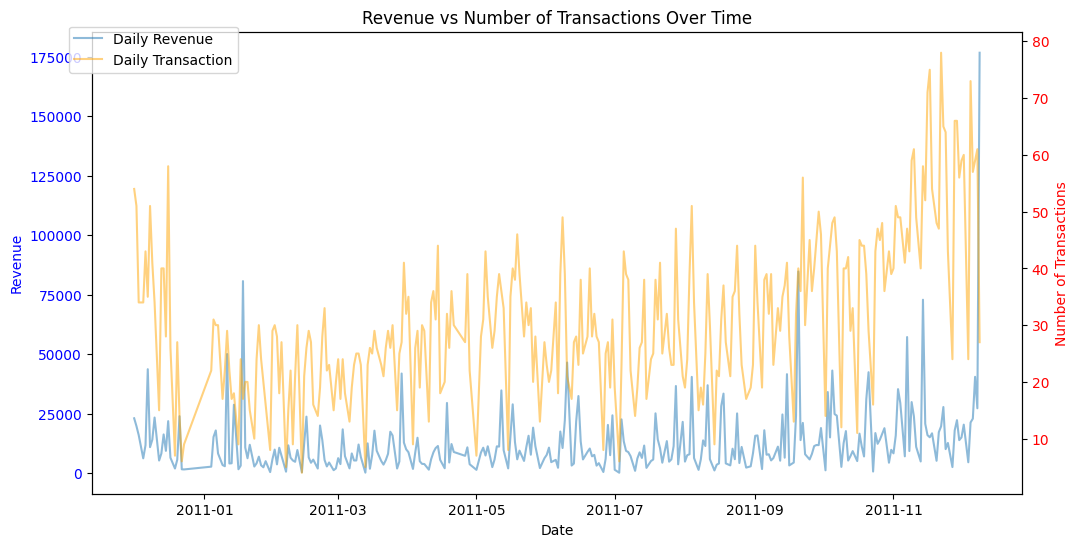

In [21]:
fig, ax1 = plt.subplots(figsize=(12,6))

revwhole = wholesalers.groupby(wholesalers["InvoiceDate"].dt.date)["TotalPrice"].sum()
trxwhole = wholesalers.groupby(wholesalers["InvoiceDate"].dt.date)["InvoiceNo"].nunique()

# Plot Revenue on Primary Y-Axis
ax1.plot(revwhole.index, revwhole, alpha=0.5, label='Daily Revenue')  # Original
ax1.set_xlabel("Date")
ax1.set_ylabel("Revenue", color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Create Secondary Y-Axis for Transactions
ax2 = ax1.twinx()
ax2.plot(trxwhole.index, trxwhole, color='orange', alpha=0.5, label='Daily Transaction')  # Original
ax2.set_ylabel("Number of Transactions", color='red')
ax2.tick_params(axis='y', labelcolor='red')

# Add legends
fig.legend(loc='upper left', bbox_to_anchor=(0.1,0.9))
plt.title("Revenue vs Number of Transactions Over Time")
plt.show()

Here wholesalers revenue per day seems stable except those spikes. Let's look at it to report

But i won't be able to understand the transaction like retail as it is over the places.

In [23]:
# Calculate the mean and standard deviation of revenue per day
mean_revenue = wholesalers["TotalPrice"].mean()
std_revenue = wholesalers["TotalPrice"].std()

# Define a threshold: Revenue above mean + 2*std is a spike
threshold = mean_revenue + 2 * std_revenue

# Identify peak days
spike_days = wholesalers[wholesalers["TotalPrice"] > threshold]
spike_days

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice
16429,537657,21623,VINTAGE UNION JACK MEMOBOARD,408,2010-12-07 16:42:00,6.38,18102.0,United Kingdom,2603.04
16435,537659,22189,CREAM HEART CARD HOLDER,1008,2010-12-07 16:43:00,2.31,18102.0,United Kingdom,2328.48
16436,537659,22188,BLACK HEART CARD HOLDER,1008,2010-12-07 16:43:00,2.31,18102.0,United Kingdom,2328.48
16438,537659,21623,VINTAGE UNION JACK MEMOBOARD,600,2010-12-07 16:43:00,6.38,18102.0,United Kingdom,3828.00
16440,537659,82484,WOOD BLACK BOARD ANT WHITE FINISH,600,2010-12-07 16:43:00,4.78,18102.0,United Kingdom,2868.00
...,...,...,...,...,...,...,...,...,...
533812,581115,22413,METAL SIGN TAKE IT OR LEAVE IT,1404,2011-12-07 12:20:00,2.75,15195.0,United Kingdom,3861.00
534952,581175,23084,RABBIT NIGHT LIGHT,1440,2011-12-07 15:16:00,1.79,14646.0,Netherlands,2577.60
537883,581375,21137,BLACK RECORD COVER FRAME,960,2011-12-08 12:36:00,3.39,16210.0,United Kingdom,3254.40
540061,581457,23543,WALL ART KEEP CALM,698,2011-12-08 18:43:00,4.15,18102.0,United Kingdom,2896.70


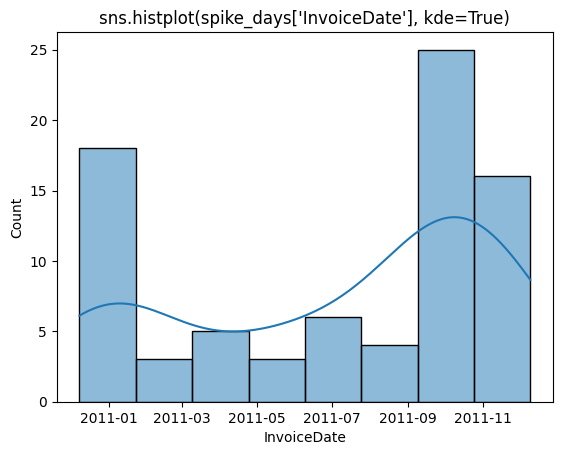

In [35]:
# Let's look at distribution of dates

sns.histplot(spike_days["InvoiceDate"], kde=True)
plt.title("sns.histplot(spike_days['InvoiceDate'], kde=True)")
plt.savefig("spikes_days.png")
plt.show()

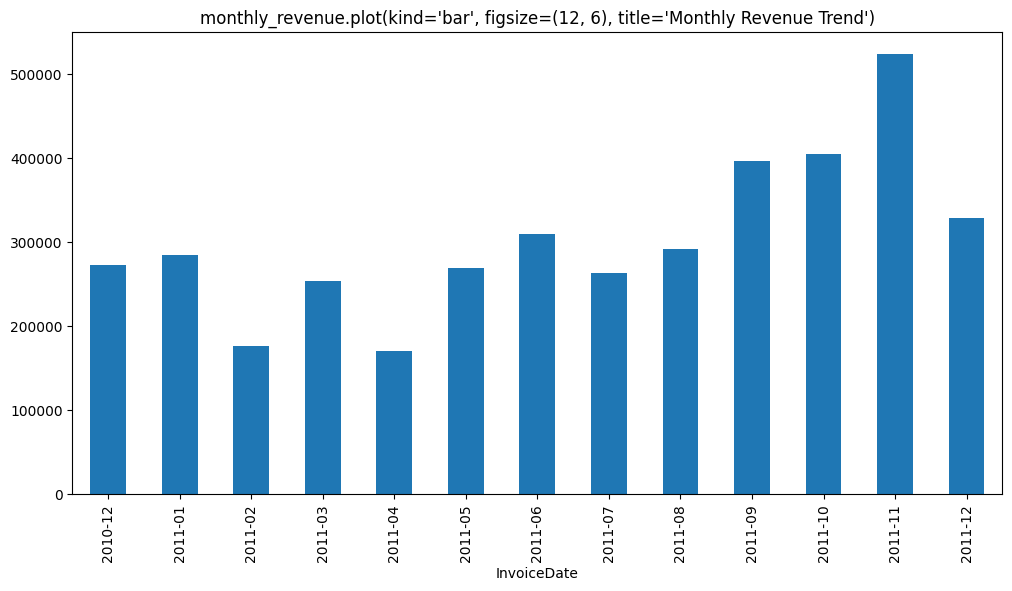

In [37]:
monthly_revenue = wholesalers.groupby(wholesalers["InvoiceDate"].dt.to_period("M"))["TotalPrice"].sum()
monthly_revenue.plot(kind="bar", figsize=(12, 6), title="Monthly Revenue Trend")
plt.title("monthly_revenue.plot(kind='bar', figsize=(12, 6), title='Monthly Revenue Trend')")
plt.savefig("monthly_rev_whole.png")
plt.show()

#### Second Question: Which product contributes most to sales?

In [7]:
real_sales = df[(df["Quantity"] > 0) & (df["UnitPrice"] > 0)].copy(deep=True)
stock_series = real_sales["StockCode"]
stock_series = stock_series.astype(str)
real_sales = real_sales[stock_series.str.contains(r'\d', na=False)]
real_sales["TotalPrice"] = real_sales["Quantity"] * real_sales["UnitPrice"]

"""
real_sales = df[~(df["UnitPrice"] < 0)]
stock_series = real_sales["StockCode"]
stock_series = stock_series.astype(str)
real_sales = real_sales[stock_series.str.contains(r'\d', na=False)]
"""

'\nreal_sales = df[~(df["UnitPrice"] < 0)]\nstock_series = real_sales["StockCode"]\nstock_series = stock_series.astype(str)\nreal_sales = real_sales[stock_series.str.contains(r\'\\d\', na=False)]\n'

In [11]:
retail_sales = real_sales[real_sales["Quantity"] <= 24]
whole_sales = real_sales[real_sales["Quantity"] > 24]

###### For Retail Sales

In [22]:
# stock code to description

stockcode_desc = retail_sales.groupby("StockCode")["Description"].apply(lambda x: list(set(x))[0]).to_dict()

In [58]:
stockcode_revenue = retail_sales.groupby("StockCode")["TotalPrice"].sum().sort_values(ascending=False)
stockcode_revenue.index = stockcode_revenue.index.map(stockcode_desc)
stockcode_revenue.head(10)

StockCode
REGENCY CAKESTAND 3 TIER              110792.96
PARTY BUNTING                          46165.04
CREAM HANGING HEART T-LIGHT HOLDER     35334.64
JUMBO BAG RED RETROSPOT                32286.86
SPOTTY BUNTING                         29215.06
JAM MAKING SET WITH JARS               25906.90
SET OF 3 CAKE TINS PANTRY DESIGN       25649.07
CHOCOLATE HOT WATER BOTTLE             25286.34
ASSORTED COLOUR BIRD ORNAMENT          25005.42
CHILLI LIGHTS                          24956.01
Name: TotalPrice, dtype: float64

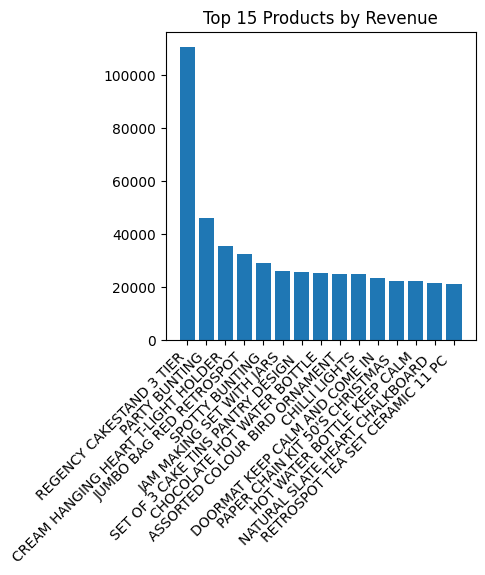

In [67]:
top_n = 15
top_products = stockcode_revenue.head(top_n)
fig, ax = plt.subplots(figsize=(4, 4))
ax.bar(top_products.index, top_products)
ax.set_title(f'Top {top_n} Products by Revenue')
ax.set_xticks(np.arange(top_n))
ax.set_xticklabels(top_products.index, rotation=45, ha='right')
plt.show()

As i can see that most of the revenue is coming from Regency cakestand 3 tier  
Let's look at quantity wise top product and see if there is changes to ranking indicating unit price coming
into play

In [68]:
stockcode_quantity = retail_sales.groupby("StockCode")["Quantity"].sum().sort_values(ascending=False)
stockcode_quantity.index = stockcode_quantity.index.map(stockcode_desc)
stockcode_quantity.head(10)

StockCode
PACK OF 72 RETROSPOT CAKE CASES       16343
ASSORTED COLOUR BIRD ORNAMENT         14462
JUMBO BAG RED RETROSPOT               14046
CREAM HANGING HEART T-LIGHT HOLDER    11568
LUNCH BAG RED RETROSPOT               10639
SMALL POPCORN HOLDER                  10358
JAM MAKING SET PRINTED                 9698
JUMBO BAG VINTAGE DOILEY               9306
PACK OF 60 PINK PAISLEY CAKE CASES     9074
60 TEATIME FAIRY CAKE CASES            8926
Name: Quantity, dtype: int64

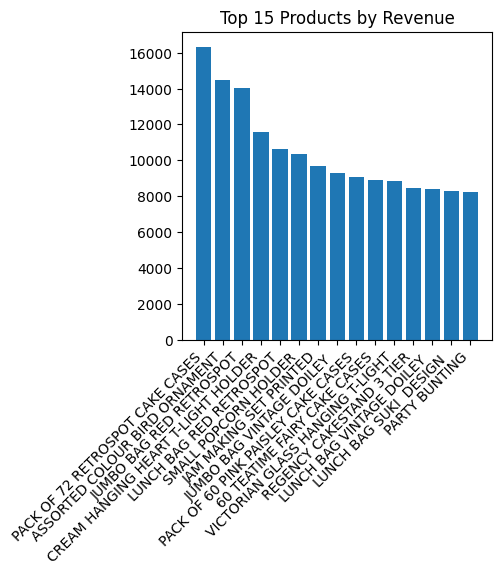

In [69]:
top_n = 15
top_products = stockcode_quantity.head(top_n)
fig, ax = plt.subplots(figsize=(4, 4))
ax.bar(top_products.index, top_products)
ax.set_title(f'Top {top_n} Products by Revenue')
ax.set_xticks(np.arange(top_n))
ax.set_xticklabels(top_products.index, rotation=45, ha='right')
plt.show()

In [50]:
# Group by StockCode and calculate total revenue and total quantity sold
product_stats = retail_sales.groupby("StockCode").agg(
    TotalRevenue=('TotalPrice', 'sum'),
    TotalQuantity=('Quantity', 'sum')
).reset_index()

# Sort by TotalRevenue and TotalQuantity to get rankings
product_stats['RevenueRank'] = product_stats['TotalRevenue'].rank(ascending=False, method='min')
product_stats['QuantityRank'] = product_stats['TotalQuantity'].rank(ascending=False, method='min')
product_stats["Description"] = product_stats["StockCode"].map(stockcode_desc)

# Display the top products by revenue and quantity
print(product_stats.sort_values(by='RevenueRank')["Description"].head(10))  # Top by revenue
print(product_stats.sort_values(by='QuantityRank')["Description"].head(10))  # Top by quantity

1217              REGENCY CAKESTAND 3 TIER
2441                         PARTY BUNTING
3498    CREAM HANGING HEART T-LIGHT HOLDER
3487               JUMBO BAG RED RETROSPOT
2043                        SPOTTY BUNTING
1729              JAM MAKING SET WITH JARS
1498     SET OF 3 CAKE TINS PANTRY DESIGN 
941             CHOCOLATE HOT WATER BOTTLE
2638         ASSORTED COLOUR BIRD ORNAMENT
2505                         CHILLI LIGHTS
Name: Description, dtype: object
360        PACK OF 72 RETROSPOT CAKE CASES
2638         ASSORTED COLOUR BIRD ORNAMENT
3487               JUMBO BAG RED RETROSPOT
3498    CREAM HANGING HEART T-LIGHT HOLDER
96                 LUNCH BAG RED RETROSPOT
1017                  SMALL POPCORN HOLDER
1730                JAM MAKING SET PRINTED
1961             JUMBO BAG VINTAGE DOILEY 
848     PACK OF 60 PINK PAISLEY CAKE CASES
2669           60 TEATIME FAIRY CAKE CASES
Name: Description, dtype: object


Key Observations

Revenue Insights:

"Regency Cakestand 3 Tier" is a clear outlier in revenue, contributing 110,792.96 which is significantly
higher than the next product (46,165.04).

The revenue distribution for other products falls smoothly, indicating a long-tail effect where a few products drive most of the revenue.

Quantity Insights:

The top quantity products are more evenly distributed, with "Pack of 72 Retrospot Cake Cases" leading at 16,343 units.

There is no single dominant product in terms of quantity, and the drop-off is gradual.

There are three segment of product i am dealing with:

High Revenue, Low Quantity: Products with high revenue but low quantity sold are likely premium or high-priced items.

High Quantity, Low Revenue: Products with high quantity sold but low revenue are likely low-priced or high-volume items.

Balanced Products: Products that rank similarly in both revenue and quantity are likely well-balanced in terms of price and demand.

In [76]:
# let's look at balanced products which appear in both rankings

balanced_products = list(stockcode_revenue.head(10).index.intersection(stockcode_quantity.head(10).index))
balanced_products

['CREAM HANGING HEART T-LIGHT HOLDER',
 'JUMBO BAG RED RETROSPOT',
 'ASSORTED COLOUR BIRD ORNAMENT']

In [86]:
product_stats.sort_values(by='RevenueRank').head(1)

,StockCode,TotalRevenue,TotalQuantity,RevenueRank,QuantityRank,Description,Segment
1217,22423,110792.96,8437,1.0,12.0,REGENCY CAKESTAND 3 TIER,Balanced Products


In [78]:
product_stats[product_stats["Description"].isin(balanced_products)]

,StockCode,TotalRevenue,TotalQuantity,RevenueRank,QuantityRank,Description
2638,84879,25005.42,14462,9.0,2.0,ASSORTED COLOUR BIRD ORNAMENT
3487,85099B,32286.86,14046,4.0,3.0,JUMBO BAG RED RETROSPOT
3498,85123A,35334.64,11568,3.0,4.0,CREAM HANGING HEART T-LIGHT HOLDER


`Assorted Colour bird ornament` is from second segment and rest both are balanced products

Recomedations:

1. Leverage the Outlier:

Highlight "Regency Cakestand 3 Tier" in marketing campaigns to maximize its revenue potential.  
Explore opportunities to create complementary premium products.

2. Optimize High-Volume Products:

Use low-cost, high-volume products like "Pack of 72 Retrospot Cake Cases" to attract customers and drive traffic.  
Consider bundling these products with higher-margin items to increase profitability.

3. Focus on Balanced Products:

Invest in marketing and inventory for balanced products like "Cream Hanging Heart T-Light Holder" to maintain their strong performance.

For CEO message, first i will show revenue wise and then quantity wise bar chart, then comment upon smooth decline
and outlier which is regency.. . Lastly will shows products in each segment. Then let's explore into regency for a while

In [88]:
# let's look at regency cakestand a bit

regency_cakestand = retail_sales[retail_sales["StockCode"] == 22423]
regency_cakestand

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice
880,536477,22423,REGENCY CAKESTAND 3 TIER,16,2010-12-01 12:27:00,10.95,16210.0,United Kingdom,175.20
936,536502,22423,REGENCY CAKESTAND 3 TIER,2,2010-12-01 12:36:00,12.75,16552.0,United Kingdom,25.50
1092,536525,22423,REGENCY CAKESTAND 3 TIER,2,2010-12-01 12:54:00,12.75,14078.0,United Kingdom,25.50
1155,536528,22423,REGENCY CAKESTAND 3 TIER,1,2010-12-01 13:17:00,12.75,15525.0,United Kingdom,12.75
1197,536530,22423,REGENCY CAKESTAND 3 TIER,1,2010-12-01 13:21:00,12.75,17905.0,United Kingdom,12.75
...,...,...,...,...,...,...,...,...,...
539891,581449,22423,REGENCY CAKESTAND 3 TIER,1,2011-12-08 17:37:00,12.75,12748.0,United Kingdom,12.75
539892,581449,22423,REGENCY CAKESTAND 3 TIER,1,2011-12-08 17:37:00,12.75,12748.0,United Kingdom,12.75
540216,581472,22423,REGENCY CAKESTAND 3 TIER,2,2011-12-08 19:55:00,12.75,15796.0,United Kingdom,25.50
541231,581495,22423,REGENCY CAKESTAND 3 TIER,10,2011-12-09 10:20:00,12.75,14051.0,United Kingdom,127.50


In [89]:
# let's checkout unit price distribution

regency_cakestand['UnitPrice'].describe()

count    1916.000000
mean       14.085689
std         4.256630
min         4.000000
25%        12.750000
50%        12.750000
75%        12.750000
max        32.040000
Name: UnitPrice, dtype: float64

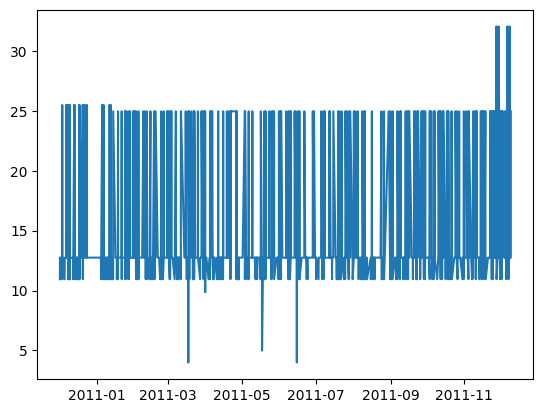

In [90]:
# looking at unit price according to date

plt.plot(regency_cakestand["InvoiceDate"], regency_cakestand["UnitPrice"])

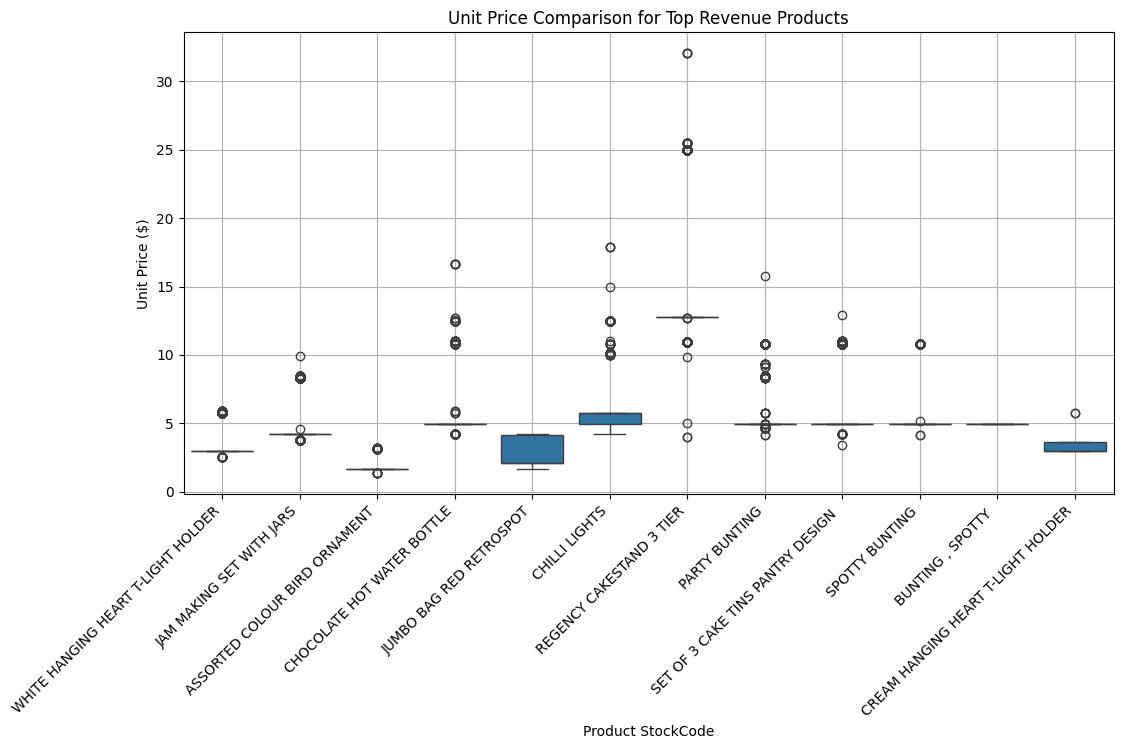

In [96]:
# looking at above data unit price is fluctuating

# Get unit price distribution for top revenue products
top_revenue_products = retail_sales.groupby('StockCode')['TotalPrice'].sum().nlargest(10).index
top_revenue_data = retail_sales[retail_sales['StockCode'].isin(top_revenue_products)]

# Box plot to compare unit prices
plt.figure(figsize=(12, 6))
sns.boxplot(x='Description', y='UnitPrice', data=top_revenue_data)
plt.title('Unit Price Comparison for Top Revenue Products')
plt.xlabel('Product StockCode')
plt.ylabel('Unit Price ($)')
plt.xticks(rotation=45, ha='right')
plt.grid(True)
plt.show()

Removing outliers and only looking at box, regency cakestand has higher unit price and thus is a premium product

###### whole sale product review

In [109]:
product_stats = whole_sales.groupby("StockCode").agg(
    TotalRevenue=('TotalPrice', 'sum'),
    TotalQuantity=('Quantity', 'sum'),
    TransactionAmt=('InvoiceNo', 'nunique')
).reset_index()
sc_desc = whole_sales.groupby("StockCode")["Description"].apply(lambda x: list(set(x))[0]).to_dict()
product_stats["Description"] = product_stats['StockCode'].map(sc_desc)
product_stats

,StockCode,TotalRevenue,TotalQuantity,TransactionAmt,Description
0,10002,379.10,446,6,INFLATABLE POLITICAL GLOBE
1,10080,28.86,74,2,GROOVY CACTUS INFLATABLE
2,10120,12.60,60,2,DOGGY RUBBER
3,10125,458.50,590,8,MINI FUNKY DESIGN TAPES
4,10133,618.61,1205,22,COLOURING PENCILS BROWN TUBE
...,...,...,...,...,...
2226,90209B,147.00,84,2,GREEN ENAMEL+GLASS HAIR COMB
2227,90209C,357.00,204,3,PINK ENAMEL+GLASS HAIR COMB
2228,90210C,75.00,60,1,RED ACRYLIC FACETED BANGLE
2229,90210D,75.00,60,1,PURPLE ACRYLIC FACETED BANGLE


In [117]:
# Let's look at top product revenue wise
print(product_stats.sort_values(by="TotalRevenue", ascending=False)[["StockCode", "Description", "TotalRevenue", "TransactionAmt"]].head(10).to_string(index=False))

StockCode                        Description  TotalRevenue  TransactionAmt
    23843        PAPER CRAFT , LITTLE BIRDIE     168469.60               1
    23166     MEDIUM CERAMIC TOP STORAGE JAR      79610.48              31
   85123A CREAM HANGING HEART T-LIGHT HOLDER      69184.16             354
    22423           REGENCY CAKESTAND 3 TIER      63691.78             101
   85099B            JUMBO BAG RED RETROSPOT      62053.19             293
    47566                      PARTY BUNTING      53339.29             154
    23084                 RABBIT NIGHT LIGHT      51771.94             189
    22086    PAPER CHAIN KIT 50'S CHRISTMAS       42620.72             170
    22502     PICNIC BASKET WICKER 60 PIECES      41198.70              10
    22197               SMALL POPCORN HOLDER      41034.07             316


In [118]:
# Let's look at top product quantity wise
print(product_stats.sort_values(by="TotalQuantity", ascending=False)[["StockCode", "Description", "TotalQuantity", "TransactionAmt"]].head(10).to_string(index=False))

StockCode                        Description  TotalQuantity  TransactionAmt
    23843        PAPER CRAFT , LITTLE BIRDIE          80995               1
    23166     MEDIUM CERAMIC TOP STORAGE JAR          76471              31
    84077  WORLD WAR 2 GLIDERS ASSTD DESIGNS          54699             463
    22197               SMALL POPCORN HOLDER          46563             316
   85099B            JUMBO BAG RED RETROSPOT          34428             293
    22492            MINI PAINT SET VINTAGE           26493             324
   85123A CREAM HANGING HEART T-LIGHT HOLDER          26092             354
    23084                 RABBIT NIGHT LIGHT          23693             189
    17003                BROCADE RING PURSE           22669             164
    84879      ASSORTED COLOUR BIRD ORNAMENT          21999             254


In [105]:
# here we can again see three segments but looking at revenue the paper craft has highest revenue
# this also follows along the quantity side
# this was one time purchase, let's create another column with showing number of purcheses acc to invoiceno

whole_sales[whole_sales["StockCode"] == 23843]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice
540421,581483,23843,"PAPER CRAFT , LITTLE BIRDIE",80995,2011-12-09 09:15:00,2.08,16446.0,United Kingdom,168469.6


In [119]:
# leaving paper craft medium ceramic product is bought many times, let's look if it is single customer
# or multiple people

ceramic = whole_sales[whole_sales["StockCode"] == 23166]
ceramic

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice
61619,541431,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215,2011-01-18 10:01:00,1.04,12346.0,United Kingdom,77183.60
186770,552882,23166,MEDIUM CERAMIC TOP STORAGE JAR,96,2011-05-12 10:10:00,1.04,14646.0,Netherlands,99.84
188644,553052,23166,MEDIUM CERAMIC TOP STORAGE JAR,48,2011-05-13 10:14:00,1.04,15251.0,United Kingdom,49.92
191128,553339,23166,MEDIUM CERAMIC TOP STORAGE JAR,48,2011-05-16 12:19:00,1.04,15125.0,United Kingdom,49.92
194462,553607,23166,MEDIUM CERAMIC TOP STORAGE JAR,240,2011-05-18 10:47:00,1.04,16684.0,United Kingdom,249.60
201570,554307,23166,MEDIUM CERAMIC TOP STORAGE JAR,96,2011-05-23 14:59:00,1.04,12989.0,United Kingdom,99.84
206594,554946,23166,MEDIUM CERAMIC TOP STORAGE JAR,48,2011-05-27 14:22:00,1.04,18242.0,United Kingdom,49.92
222318,556415,23166,MEDIUM CERAMIC TOP STORAGE JAR,48,2011-06-10 12:19:00,1.04,12409.0,Switzerland,49.92
228160,556917,23166,MEDIUM CERAMIC TOP STORAGE JAR,96,2011-06-15 13:37:00,1.04,12415.0,Australia,99.84
249933,558964,23166,MEDIUM CERAMIC TOP STORAGE JAR,48,2011-07-05 10:58:00,1.04,14235.0,United Kingdom,49.92


In [ ]:
# eyeballing the data i can see the quantity is concentrated in 48 and it is not single customer but multiple
# buying same quantity. Unit Price doesn't changes except one. There are multiple customer
# Lastly at start there was an huge order.
# Also this order was at January and then order start coming in from May onwards

In [121]:
# let's look at customer buying that bulk paper craft

real_sales[real_sales["CustomerID"] == 16446]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice
194354,553573,22980,PANTRY SCRUBBING BRUSH,1,2011-05-18 09:52:00,1.65,16446.0,United Kingdom,1.65
194355,553573,22982,PANTRY PASTRY BRUSH,1,2011-05-18 09:52:00,1.25,16446.0,United Kingdom,1.25
540421,581483,23843,"PAPER CRAFT , LITTLE BIRDIE",80995,2011-12-09 09:15:00,2.08,16446.0,United Kingdom,168469.60


*Key Observations*

- Revenue-Wise Top Products:

"Paper Craft, Little Birdie" generates the highest revenue ($168,469.60) despite having only 1 transaction. This suggests a single large bulk purchase.

Other high-revenue products like "Medium Ceramic Top Storage Jar" and "Regency Cakestand 3 Tier" have more transactions, indicating consistent demand.

- Quantity-Wise Top Products:

"Paper Craft, Little Birdie" also tops the quantity list with 80,995 units, confirming it’s a high-volume product.

Products like "World War 2 Gliders Asstd Designs" and "Small Popcorn Holder" are high in quantity but lower in revenue, suggesting they are low-cost, high-volume items.

Customer: 16446 has bulked order "Paper Craft, Little Birdie". We can further contact and see if the person is middle man or he or she bought this thing for one time.  
But looking at the data above, i seem to doubt the customer is wholesaler as buying single product with 1 quantity but again where have we restrict wholesaler to buy items in bulk from store.

But this brings the question, are the wholesalers above really wholesellers. One of the distinguished feature of wholeselling is that the product is bought cheaply. I don't want to get into details will keep for future and won't change above naming as will take alot of time. So from now on, will refer them as small and large quantity purchases. This way i can show above trends without these big purchases affecting it.

#### Third Question: Which country contributes most to sales

In [14]:
# let's look at country revenue wise

print("Small Sales:\n")
print(small_sales.groupby("Country")['TotalPrice'].sum().sort_values(ascending=False).head(10))
print("\nLargeSales:\n")
print(large_sales.groupby("Country")['TotalPrice'].sum().sort_values(ascending=False).head(10))

Small Sales:

Country
United Kingdom    5543400.74
Germany            160220.02
EIRE               154395.96
France             142994.52
Spain               37646.21
Switzerland         37385.77
Belgium             33098.20
Netherlands         28652.20
Norway              23120.76
Portugal            22651.96
Name: TotalPrice, dtype: float64

LargeSales:

Country
United Kingdom    3206026.75
Netherlands        255237.14
EIRE               122008.34
Australia          120253.72
Germany             45349.87
France              41774.22
Japan               33986.48
Sweden              31059.34
Spain               18078.90
Switzerland         15702.13
Name: TotalPrice, dtype: float64


In [15]:
# most of the revenue is generated from United Kingdom and it is infact a huge part of revenue
# as it is 10 times the second one in both cases
# let's look at number of transactions in both cases

print("Small Sales:\n")
print(small_sales.groupby("Country")['InvoiceNo'].nunique().sort_values(ascending=False).head(10))
print("\nLargeSales:\n")
print(large_sales.groupby("Country")['TotalPrice'].nunique().sort_values(ascending=False).head(10))

Small Sales:

Country
United Kingdom    16734
Germany             434
France              371
EIRE                271
Belgium              97
Spain                83
Netherlands          70
Portugal             49
Switzerland          47
Australia            44
Name: InvoiceNo, dtype: int64

LargeSales:

Country
United Kingdom    2262
EIRE               260
Netherlands        254
Australia          212
Germany            157
France             146
Japan               94
Switzerland         89
Sweden              69
Norway              62
Name: TotalPrice, dtype: int64


In [16]:
# let's look at total quantity verses Country

print("Small Sales:\n")
print(small_sales.groupby("Country")['Quantity'].sum().sort_values(ascending=False).head(10))
print("\nLargeSales:\n")
print(large_sales.groupby("Country")['Quantity'].sum().sort_values(ascending=False).head(10))

Small Sales:

Country
United Kingdom    2436013
Germany             81814
France              75514
EIRE                66074
Switzerland         18178
Spain               18138
Belgium             17510
Portugal            11621
Norway               9867
Netherlands          8200
Name: Quantity, dtype: int64

LargeSales:

Country
United Kingdom    2218311
Netherlands        192058
EIRE                81094
Australia           78188
Germany             36325
France              35758
Sweden              32947
Japan               24944
Switzerland         12349
Spain                9593
Name: Quantity, dtype: int64


Looking at above data points these are key observations:

1. United Kingdom is major source of revenue in both small and large sales and has highest order. The numbers are 10x the second record in both revenue and order number.

2. In small sales, countries like Germany, EIRE, France is another force which is buying product around 200 to 400. Compared to rest which has order value less than 100. This is also reflected in revenue wise where difference between France and Spain is about 60K USD. and then it stays similar

3. In large sales, EIRE, Netherlands, Australia, Germany and France have higher number but difference between Autralia and Germany is 50 less orders and but total revenue drops by half. Suggesting that Germany and France bought cheap products or low quantity products each transactions which bumps up the number of order value but the amount of product being sold is still less. As we can see from above quantity data, the amount of quantity bought by two countries is half the Australia.

Your analysis is spot on! You’ve identified key trends and patterns in the sales data across different countries. Let’s summarize and refine your findings to make them more actionable for the CEO or stakeholders.

---

**Key Observations**

**1. United Kingdom Dominates Sales**:

- **Revenue**: The UK generates **10x more revenue** than the next country (Germany in small sales, Netherlands in large sales).
- **Orders**: The UK has **16734 small sales orders** and **2262 large sales orders**, far exceeding other countries.
- **Quantity**: The UK accounts for **2.4M units (small sales)** and **2.2M units (large sales)**, again dominating the quantity sold.

**Inference**: The UK is your **primary market**. Focus on retaining and growing this market through targeted marketing, loyalty programs, and efficient supply chain management.

---

**2. Secondary Markets (Germany, EIRE, France, Netherlands, Australia)**:

- **Small Sales**:
  - **Germany, EIRE, and France** are the next significant contributors in terms of **revenue** and **orders**.
  - However, the revenue difference between **France ($142K)** and **Spain ($37K)** is stark, indicating a drop-off after the top 3.
- **Large Sales**:
  - **EIRE, Netherlands, and Australia** are the next major contributors.
  - **Germany and France** have higher order counts but lower revenue and quantity compared to Australia, suggesting they purchase **lower-priced or smaller-quantity items**.

**Inference**: These countries represent **secondary markets**. Focus on:
- **Upselling**: Encourage larger purchases or higher-value products in Germany and France.
- **Market Penetration**: Increase marketing efforts in Australia, Netherlands, and EIRE to boost revenue and quantity.

---

**3. Discrepancy Between Orders, Revenue, and Quantity**:

- **Germany and France**:
  - High order counts but lower revenue and quantity suggest they purchase **low-cost or small-quantity items**.
  - Example: Germany has **434 small sales orders** but only **$160K in revenue** and **81K units sold**.
- **Australia**:
  - Fewer orders but higher revenue and quantity suggest they purchase **higher-value or bulk items**.
  - Example: Australia has **212 large sales orders** but **$120K in revenue** and **78K units sold**.

**Inference**: 
- **Germany and France**: Focus on **bundling** or **cross-selling** to increase average order value.
- **Australia**: Continue targeting bulk buyers and high-value customers.

---

**Recommendations for the CEO**

**1. Focus on the UK**:

- **Retention**: Implement loyalty programs or exclusive offers for UK customers.
- **Growth**: Explore opportunities to increase market share in the UK through targeted campaigns.

**2. Optimize Secondary Markets**:

- **Germany and France**:
  - Introduce **bundled offers** or **discounts for bulk purchases** to increase revenue per transaction.
  - Analyze customer preferences to identify high-margin products for upselling.
- **Australia, Netherlands, and EIRE**:
  - Increase marketing efforts to attract more bulk buyers.
  - Offer **incentives for large orders** to boost revenue and quantity.

**3. Analyze Product Preferences by Country**:

- Identify which products are popular in each country and tailor marketing strategies accordingly.
  - Example: If Germany buys more low-cost items, introduce **premium versions** of those products.

**4. Improve Supply Chain for High-Performing Markets**:

- Ensure efficient inventory management and delivery for the UK and other high-performing countries to maintain customer satisfaction.

**5. Explore Underperforming Markets**:

- Countries like **Spain, Switzerland, and Norway** have lower revenue and order counts. Investigate why and explore opportunities to grow these markets.

#### Fourth Question: How is business performing Monthly

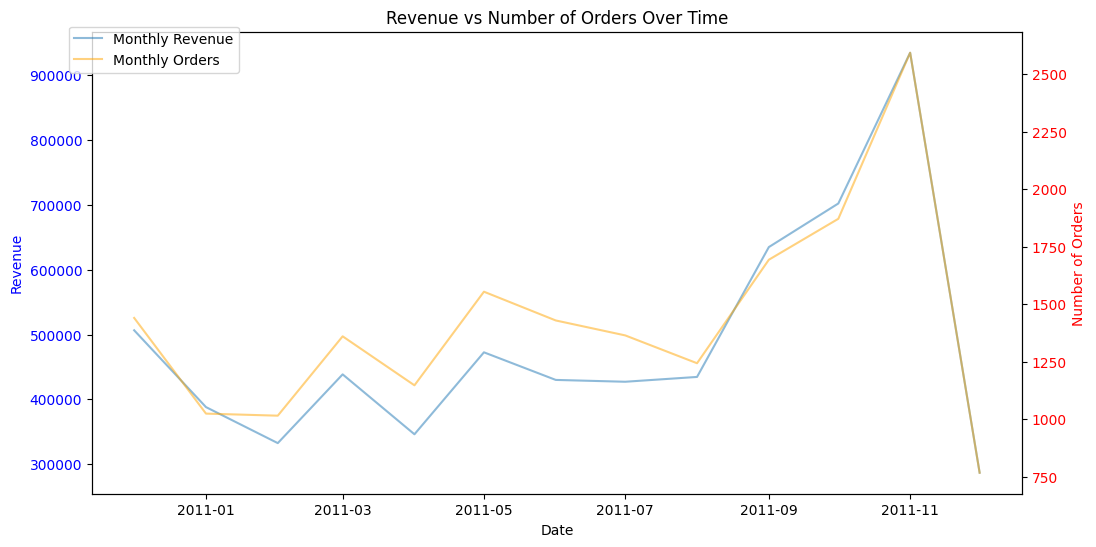

In [29]:
# let's first look at monthly revenue trend with monthly order sales for small sales

fig, ax1 = plt.subplots(figsize=(12,6))

small_monthly = small_sales.groupby("YearMonth").agg(
    TotalRevenue=("TotalPrice", "sum"),
    TotalOrders=("InvoiceNo", "nunique")
)

# Plot Revenue on Primary Y-Axis
ax1.plot(small_monthly.index.to_timestamp(), small_monthly["TotalRevenue"], alpha=0.5, label='Monthly Revenue')  # Original
ax1.set_xlabel("Date")
ax1.set_ylabel("Revenue", color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Create Secondary Y-Axis for Transactions
ax2 = ax1.twinx()
ax2.plot(small_monthly.index.to_timestamp(), small_monthly["TotalOrders"], color='orange', alpha=0.5, label='Monthly Orders')  # Original
ax2.set_ylabel("Number of Orders", color='red')
ax2.tick_params(axis='y', labelcolor='red')

# Add legends
fig.legend(loc='upper left', bbox_to_anchor=(0.1,0.9))
plt.title("Revenue vs Number of Orders Over Time")
plt.show()

Looking at above plot, i can see that november was highest (taking grain of salt as december only had 9 days worth of data). So i can confidently say that revenue and order number has increased during the time period the data is recorded. Here i can also seeing downward from december of 2010 to 2011 january. Can't comment upon things like business does well in december or holiday season as can see peaks in both sides because i don't have bigger time frame to confidently say it.

Also there are peaks in March and May months. Overall the business has increased it's revenue alot according the data given by november.

Key Observations

1. Overall Growth Trend:

Revenue Growth: Revenue increased significantly from 506KinDecember2010∗∗to∗∗934K in November 2011, indicating strong growth over the year.

Order Growth: The number of orders also grew from 1440 in December 2010 to 2593 in November 2011, reflecting increased customer engagement.

Inference: The business experienced steady growth throughout the year, with a notable peak in November.

2. Seasonal Peaks:

November Peak: November had the highest revenue ($934K) and most orders (2593), suggesting a potential holiday season effect (e.g., Black Friday, Christmas shopping).

December Dip: December 2011 had only 9 days of data, so the drop in revenue and orders is not representative of the full month. However, December 2010 had strong performance, indicating that December could also be a peak month if full data were available.

Inference: November and December are likely peak shopping months, possibly due to holiday sales and promotions.

3. Monthly Fluctuations:

March and May Peaks: Revenue and orders peaked in March (438K,1360orders)∗∗and∗∗May(472K, 1554 orders), indicating potential seasonal demand or successful marketing campaigns during these months.

January Dip: Revenue and orders dropped in January 2011 ($388K, 1024 orders) compared to December 2010, which is common after the holiday season.

Inference: The business experiences monthly fluctuations, with certain months (e.g., March, May, November) performing exceptionally well.

Recommendations for the CEO

1. Capitalize on Peak Months:
November and December: Plan holiday promotions, discounts, and marketing campaigns to maximize revenue during these peak months.

March and May: Investigate what drove the peaks in these months (e.g., seasonal demand, marketing efforts) and replicate successful strategies.

2. Address January Dip:
Post-Holiday Strategies: Implement post-holiday sales or loyalty programs to maintain customer engagement after the holiday season.

3. Analyze Growth Drivers:
Identify the factors driving the steady growth throughout the year (e.g., new customer acquisition, product launches, marketing campaigns).

Focus on scaling these drivers to sustain growth.

4. Expand Data Collection:
Collect data for a longer time frame to better understand seasonal trends and validate observations (e.g., full December data).

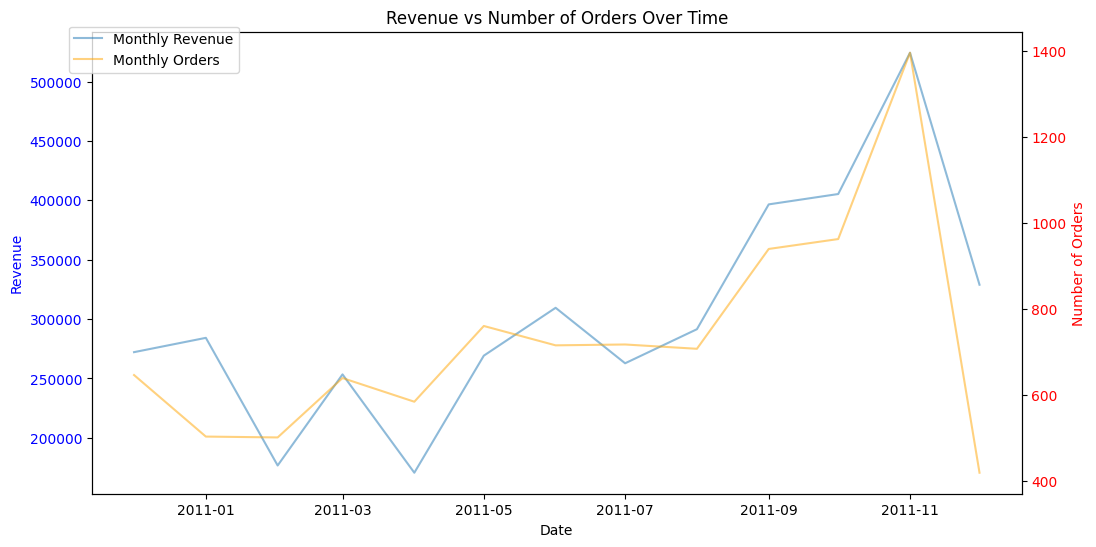

In [31]:
# let's first look at monthly revenue trend with monthly order sales for large sales

fig, ax1 = plt.subplots(figsize=(12,6))

large_monthly = large_sales.groupby("YearMonth").agg(
    TotalRevenue=("TotalPrice", "sum"),
    TotalOrders=("InvoiceNo", "nunique")
)

# Plot Revenue on Primary Y-Axis
ax1.plot(large_monthly.index.to_timestamp(), large_monthly["TotalRevenue"], alpha=0.5, label='Monthly Revenue')  # Original
ax1.set_xlabel("Date")
ax1.set_ylabel("Revenue", color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Create Secondary Y-Axis for Transactions
ax2 = ax1.twinx()
ax2.plot(large_monthly.index.to_timestamp(), large_monthly["TotalOrders"], color='orange', alpha=0.5, label='Monthly Orders')  # Original
ax2.set_ylabel("Number of Orders", color='red')
ax2.tick_params(axis='y', labelcolor='red')

# Add legends
fig.legend(loc='upper left', bbox_to_anchor=(0.1,0.9))
plt.title("Revenue vs Number of Orders Over Time")
plt.show()

Same kind of behaviour as small sales (but again maybe i am fucking it up as explained in todo)

#### Fifth Question: Are there operational inefficiencies (e.g., high returns, stock issues)?

In [46]:
# i don't know if products with invoice number 'C' is return product or cancelled product as that
# product invoice number with 'C' i can't see normally in database as seen in previous jupyter notebook
# But let's leave it and find how losses are there for it. Let's denote these products as cancelled as
# used by deepseek

cancelled_products = df[df["InvoiceNo"].str.startswith("C", na=False)]
stock_series = cancelled_products["StockCode"]
stock_series = stock_series.astype(str)
cancelled_products = cancelled_products[stock_series.str.contains(r'\d', na=False)]
cancelled_products["RevenueLoss"] = -1 * cancelled_products["Quantity"] * cancelled_products["UnitPrice"]
cancelled_products["YearMonth"] = cancelled_products["InvoiceDate"].dt.to_period('M')

InvoiceDate
2010-12    301
2011-01    247
2011-02    191
2011-03    281
2011-04    220
2011-05    267
2011-06    299
2011-07    236
2011-08    240
2011-09    299
2011-10    308
2011-11    396
2011-12    137
Freq: M, Name: InvoiceNo, dtype: int64


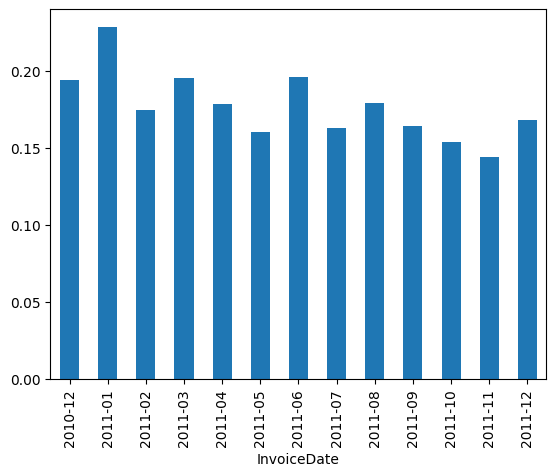

In [16]:
# let's look at return rate or others per month | return rate cause this will give idea about relativity
# with total returns

cp_monthly = cancelled_products.groupby(cancelled_products["InvoiceDate"].dt.to_period("M"))["InvoiceNo"].nunique()
print(cp_monthly)

# looking at this seems like these stays consistent but if we take total orders into account
orders_monthly = real_sales.groupby("YearMonth")["InvoiceNo"].nunique()
(cp_monthly / orders_monthly).plot.bar()
plt.show()

Ratio also remains in same band

In [26]:
# if we look at amt of revenue loss per month due to this

yearmonth_revenueloss = cancelled_products.groupby("YearMonth")["RevenueLoss"].sum()
yearmonth_revenueloss

YearMonth
2010-12     17607.86
2011-01     91576.30
2011-02      8375.87
2011-03     10675.30
2011-04     33316.91
2011-05      8948.23
2011-06     13775.84
2011-07     11409.21
2011-08     22929.52
2011-09     17044.68
2011-10     43992.16
2011-11     25010.54
2011-12    174126.76
Freq: M, Name: RevenueLoss, dtype: float64

<Axes: xlabel='YearMonth'>

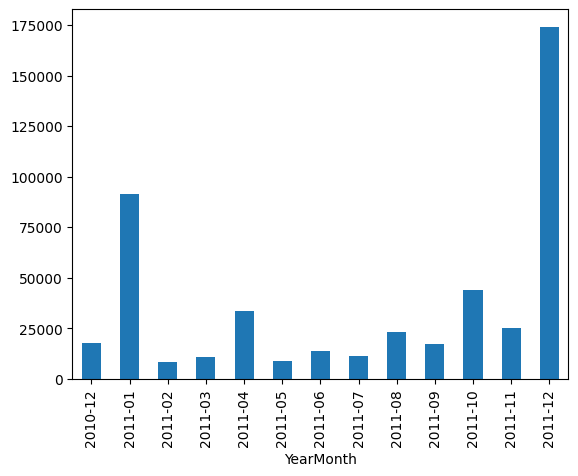

In [27]:
yearmonth_revenueloss.plot.bar()

In [31]:
(-1 * cancelled_products[cancelled_products["YearMonth"] == '2011-12']["Quantity"]).describe()

count      348.000000
mean       240.086207
std       4341.429263
min          1.000000
25%          1.000000
50%          2.000000
75%          6.000000
max      80995.000000
Name: Quantity, dtype: float64

In [40]:
cancelled_products[(-1 * cancelled_products["Quantity"]) == 80995]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,RevenueLoss,YearMonth
540422,C581484,23843,"PAPER CRAFT , LITTLE BIRDIE",-80995,2011-12-09 09:27:00,2.08,16446.0,United Kingdom,168469.6,2011-12


In [41]:
# damm so the customer order that has cancelled the order
# let's look at order transaction again

real_sales[real_sales["CustomerID"] == 16446]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice,YearMonth
194354,553573,22980,PANTRY SCRUBBING BRUSH,1,2011-05-18 09:52:00,1.65,16446.0,United Kingdom,1.65,2011-05
194355,553573,22982,PANTRY PASTRY BRUSH,1,2011-05-18 09:52:00,1.25,16446.0,United Kingdom,1.25,2011-05
540421,581483,23843,"PAPER CRAFT , LITTLE BIRDIE",80995,2011-12-09 09:15:00,2.08,16446.0,United Kingdom,168469.60,2011-12


This really teaches me two things:

1. Invoice Number with 'C' will not have same invoice number as order one as seen above
2. Will need to take these 'C' ones into account will showing revenue. Use this later for final draft for above questions

This also raises a question which is how do i handle these orders, as inflate value in each study and i don't know if the order is joke or serious to consider. For me, i will not include records like above as customer has cancelled the product order in just 15min of ordering. I don't know what criteria i should use to remove those or segment those in different group to study it separately as data analyst i want to know the truth and these are things which distort and need to be studied separately.

In [42]:
# let's look at january

(-1 * cancelled_products[cancelled_products["YearMonth"] == '2011-01']["Quantity"]).describe()

count      680.000000
mean       117.330882
std       2845.826823
min          1.000000
25%          1.000000
50%          2.000000
75%          6.000000
max      74215.000000
Name: Quantity, dtype: float64

In [43]:
cancelled_products[(-1 * cancelled_products["Quantity"]) == 74215]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,RevenueLoss,YearMonth
61624,C541433,23166,MEDIUM CERAMIC TOP STORAGE JAR,-74215,2011-01-18 10:17:00,1.04,12346.0,United Kingdom,77183.6,2011-01


In [44]:
real_sales[real_sales["CustomerID"] == 12346]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice,YearMonth
61619,541431,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215,2011-01-18 10:01:00,1.04,12346.0,United Kingdom,77183.6,2011-01


Again same kind of thing as seen above, this seriously distorted every study did till now. How do i remove or separate this?

In [58]:
# Identify large cancellations (e.g., quantities <= -1000)
large_cancellations = cancelled_products[cancelled_products['Quantity'] <= -1000]

# Find matching orders for these cancellations
anomalous_orders = real_sales[
    (real_sales['CustomerID'].isin(large_cancellations['CustomerID'])) &
    (real_sales['StockCode'].isin(large_cancellations['StockCode'])) &
    (real_sales['Quantity'].isin(-large_cancellations['Quantity']))
]

# Combine cancellations and their matching orders
anomalous_transactions = pd.concat([large_cancellations, anomalous_orders])

# Display anomalous transactions
anomalous_transactions.sort_values(by='InvoiceDate')

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,RevenueLoss,YearMonth,TotalPrice
4287,C536757,84347,ROTATING SILVER ANGELS T-LIGHT HLDR,-9360,2010-12-02 14:23:00,0.03,15838.0,United Kingdom,280.80,2010-12,NaN
52711,540815,21108,FAIRY CAKE FLANNEL ASSORTED COLOUR,3114,2011-01-11 12:55:00,2.10,15749.0,United Kingdom,NaN,2011-01,6539.40
52710,540815,21175,GIN + TONIC DIET METAL SIGN,2000,2011-01-11 12:55:00,1.85,15749.0,United Kingdom,NaN,2011-01,3700.00
52709,540815,85123A,WHITE HANGING HEART T-LIGHT HOLDER,1930,2011-01-11 12:55:00,2.55,15749.0,United Kingdom,NaN,2011-01,4921.50
61619,541431,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215,2011-01-18 10:01:00,1.04,12346.0,United Kingdom,NaN,2011-01,77183.60
61624,C541433,23166,MEDIUM CERAMIC TOP STORAGE JAR,-74215,2011-01-18 10:17:00,1.04,12346.0,United Kingdom,77183.60,2011-01,NaN
160143,C550456,85123A,WHITE HANGING HEART T-LIGHT HOLDER,-1930,2011-04-18 13:08:00,2.55,15749.0,United Kingdom,4921.50,2011-04,NaN
160142,C550456,47566B,TEA TIME PARTY BUNTING,-1300,2011-04-18 13:08:00,2.55,15749.0,United Kingdom,3315.00,2011-04,NaN
160144,C550456,21175,GIN + TONIC DIET METAL SIGN,-2000,2011-04-18 13:08:00,1.85,15749.0,United Kingdom,3700.00,2011-04,NaN
160145,C550456,21108,FAIRY CAKE FLANNEL ASSORTED COLOUR,-3114,2011-04-18 13:08:00,2.10,15749.0,United Kingdom,6539.40,2011-04,NaN


<Axes: xlabel='YearMonth'>

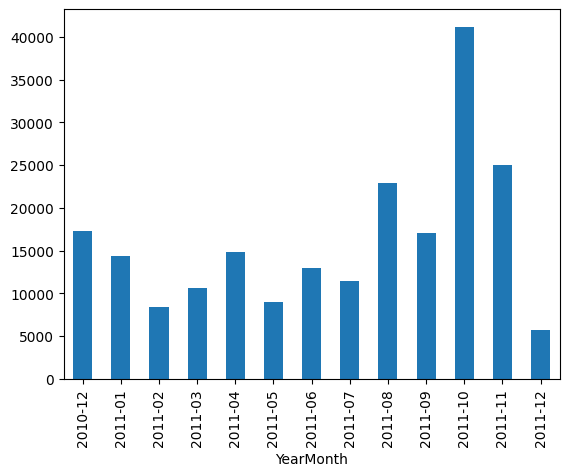

In [59]:
# here i am setting it to 1000 and not 500 or less cause yeah those orders are also like order
# and then cancel but it won't affect the overall trend in cancelled (idk i am not confident while saying this)
# let's look at trend

# Exclude anomalous transactions from the main dataset
cleaned_data = cancelled_products[~cancelled_products.index.isin(anomalous_transactions.index)]
cleaned_data.groupby("YearMonth")["RevenueLoss"].sum().plot.bar()

In [55]:
cleaned_data[cleaned_data["YearMonth"] == '2011-10']["Quantity"].describe()

count    1123.000000
mean      -17.858415
std        59.949165
min      -840.000000
25%       -12.000000
50%        -3.000000
75%        -1.000000
max        -1.000000
Name: Quantity, dtype: float64

In [60]:
cleaned_data[cleaned_data["Quantity"] == -840]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,RevenueLoss,YearMonth
390543,C570556,22147,FELTCRAFT BUTTERFLY HEARTS,-840,2011-10-11 11:10:00,1.25,16029.0,United Kingdom,1050.0,2011-10


In [62]:
real_sales[(real_sales["CustomerID"] == 16029) & (real_sales["StockCode"] == 22147)]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice,YearMonth
304101,563563,22147,FELTCRAFT BUTTERFLY HEARTS,400,2011-08-17 14:03:00,1.25,16029.0,United Kingdom,500.0,2011-08
384007,570097,22147,FELTCRAFT BUTTERFLY HEARTS,840,2011-10-07 12:05:00,1.25,16029.0,United Kingdom,1050.0,2011-10
390553,570557,22147,FELTCRAFT BUTTERFLY HEARTS,840,2011-10-11 11:15:00,1.25,16029.0,United Kingdom,1050.0,2011-10


Interesting Here, customer has ordered on 7 Oct and then cancelled on 11 Oct and re ordered 5 mins later.

Man how do i handle these data sigh...

In [256]:
# let's look at all those cancelled products and see if they are really cancelled all or not

# Identify cancelled orders (InvoiceNo starts with 'C')
cancelled_orders = df[df['InvoiceNo'].astype(str).str.startswith('C')].copy()
stock_series = cancelled_orders["StockCode"]
stock_series = stock_series.astype(str)
cancelled_orders = cancelled_orders[stock_series.str.contains(r'\d', na=False)]
cancelled_orders["TotalPrice"] = cancelled_orders["Quantity"] * cancelled_orders["UnitPrice"]
cancelled_orders["YearMonth"] = cancelled_orders["InvoiceDate"].dt.to_period("M")

cancelled_orders["Quantity"] = -1 * cancelled_orders["Quantity"]

"""
# Merge sales and cancellations on CustomerID & StockCode, but only keep valid matches
df_matched = df_sales.merge(df_cancellations, 
                            on=["CustomerID", "StockCode"], 
                            suffixes=('_sale', '_cancel'))
"""

# Merge to find matching real sales that were later canceled
# matched_sales = real_sales.merge(cancelled_orders, 
#                                   on=["CustomerID", "StockCode", "Quantity", "UnitPrice", "YearMonth"], 
#                                   suffixes=('_sale', '_cancel'))
matched_sales = real_sales.merge(cancelled_orders, 
                                  on=["CustomerID", "StockCode", "Quantity", "UnitPrice"], 
                                  suffixes=('_sale', '_cancel'))

# Filter only cases where the cancellation happened after the sale
matched_sales = matched_sales[matched_sales["InvoiceDate_cancel"] > matched_sales["InvoiceDate_sale"]]

# Keep only the most recent sale before the cancellation
# matched_sales = matched_sales.loc[matched_sales.groupby("InvoiceNo_cancel")["InvoiceDate_sale"].idxmax()]

# Selecting only real sales that had cancellations
# df_final = real_sales[real_sales["InvoiceNo"].isin(matched_sales["InvoiceNo_sale"])]

# df_final

In [257]:
matched_sales.head(3) # damm printing all of them in one row

,InvoiceNo_sale,StockCode,Description_sale,Quantity,InvoiceDate_sale,UnitPrice,CustomerID,Country_sale,TotalPrice_sale,YearMonth_sale,InvoiceNo_cancel,Description_cancel,InvoiceDate_cancel,Country_cancel,TotalPrice_cancel,YearMonth_cancel
0,536366,22632,HAND WARMER RED POLKA DOT,6,2010-12-01 08:28:00,1.85,17850.0,United Kingdom,11.10,2010-12,C543611,HAND WARMER RED RETROSPOT,2011-02-10 14:38:00,United Kingdom,-11.10,2011-02
1,536372,22632,HAND WARMER RED POLKA DOT,6,2010-12-01 09:01:00,1.85,17850.0,United Kingdom,11.10,2010-12,C543611,HAND WARMER RED RETROSPOT,2011-02-10 14:38:00,United Kingdom,-11.10,2011-02
2,536373,21071,VINTAGE BILLBOARD DRINK ME MUG,6,2010-12-01 09:02:00,1.06,17850.0,United Kingdom,6.36,2010-12,C543611,VINTAGE BILLBOARD DRINK ME MUG,2011-02-10 14:38:00,United Kingdom,-6.36,2011-02


In [258]:
matched_sales[(matched_sales["InvoiceNo_sale"] == 570097) & (matched_sales["StockCode"] == 22149)]

,InvoiceNo_sale,StockCode,Description_sale,Quantity,InvoiceDate_sale,UnitPrice,CustomerID,Country_sale,TotalPrice_sale,YearMonth_sale,InvoiceNo_cancel,Description_cancel,InvoiceDate_cancel,Country_cancel,TotalPrice_cancel,YearMonth_cancel
4557,570097,22149,FELTCRAFT 6 FLOWER FRIENDS,600,2011-10-07 12:05:00,1.85,16029.0,United Kingdom,1110.0,2011-10,C570556,FELTCRAFT 6 FLOWER FRIENDS,2011-10-11 11:10:00,United Kingdom,-1110.0,2011-10


In [261]:
matched_sales[(matched_sales["InvoiceNo_sale"] == 570557) & (matched_sales["StockCode"] == 22149)]

,InvoiceNo_sale,StockCode,Description_sale,Quantity,InvoiceDate_sale,UnitPrice,CustomerID,Country_sale,TotalPrice_sale,YearMonth_sale,InvoiceNo_cancel,Description_cancel,InvoiceDate_cancel,Country_cancel,TotalPrice_cancel,YearMonth_cancel


In [262]:
(matched_sales["InvoiceDate_cancel"] - matched_sales["InvoiceDate_sale"]).describe()

count                          4229
mean     45 days 23:49:01.007330338
std      63 days 11:10:26.533618252
min                 0 days 00:01:00
25%                 3 days 18:22:00
50%                18 days 02:35:00
75%                62 days 22:26:00
max               368 days 04:30:00
dtype: object

In [271]:
matched_sales.shape

(4229, 16)

In [272]:
cancelled_orders.shape

(8706, 10)

In [263]:
cancelled_orders[(cancelled_orders["StockCode"] == '35004C') & (cancelled_orders["CustomerID"] == 15311)]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice,YearMonth
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,1,2010-12-01 09:49:00,4.65,15311.0,United Kingdom,-4.65,2010-12
18196,C537805,35004C,SET OF 3 COLOURED FLYING DUCKS,1,2010-12-08 13:18:00,4.65,15311.0,United Kingdom,-4.65,2010-12
39381,C539640,35004C,SET OF 3 COLOURED FLYING DUCKS,3,2010-12-20 15:27:00,4.65,15311.0,United Kingdom,-13.95,2010-12
78333,C542866,35004C,SET OF 3 COLOURED FLYING DUCKS,2,2011-02-01 12:14:00,4.65,15311.0,United Kingdom,-9.30,2011-02


In [264]:
real_sales[(real_sales["StockCode"] == '35004C') & (real_sales['CustomerID'] == 15311)]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice,YearMonth
9200,537195,35004C,SET OF 3 COLOURED FLYING DUCKS,12,2010-12-05 13:55:00,4.65,15311.0,United Kingdom,55.8,2010-12
28630,538651,35004C,SET OF 3 COLOURED FLYING DUCKS,12,2010-12-13 15:07:00,4.65,15311.0,United Kingdom,55.8,2010-12
44157,540157,35004C,SET OF 3 COLOURED FLYING DUCKS,12,2011-01-05 11:41:00,4.65,15311.0,United Kingdom,55.8,2011-01
59542,541293,35004C,SET OF 3 COLOURED FLYING DUCKS,12,2011-01-17 13:39:00,4.65,15311.0,United Kingdom,55.8,2011-01


In [235]:
fully_returnedtd  = (matched_sales["InvoiceDate_cancel"] - matched_sales["InvoiceDate_sale"])

In [265]:
timedelta_ns = np.percentile(fully_returnedtd, 70)
days = timedelta_ns / np.timedelta64(1, 'D')
hours = (timedelta_ns % np.timedelta64(1, 'D')) / np.timedelta64(1, 'h')
minutes = (timedelta_ns % np.timedelta64(1, 'h')) / np.timedelta64(1, 'm')
print(f"{int(days)} days, {int(hours)} hours, {int(minutes)} minutes")

23 days, 0 hours, 23 minutes


From above we can see that there are two types of transactions with invoice number starting with 'C'. First one is order and fully cancell the order. The second one is order and returning few of the orders which is partial returns. Here is the thing, what threshold i should use for days between order and cancel such that one is consider order -> cancel and other is consider is returns. Let the threshold be >= 13 days.

<Axes: xlabel='YearMonth'>

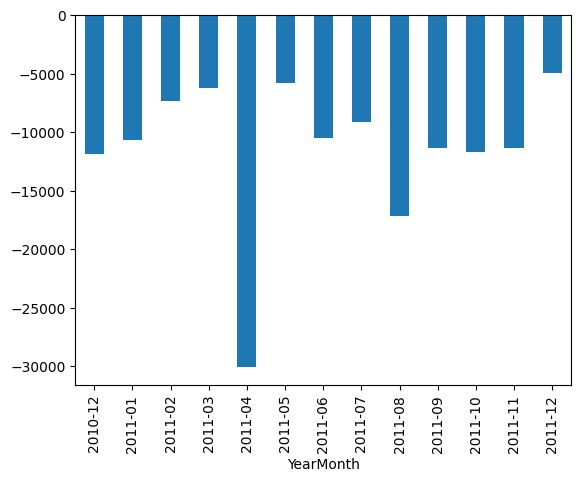

In [266]:
matched_new = matched_sales[(matched_sales["InvoiceDate_cancel"] - matched_sales["InvoiceDate_sale"]) <= np.timedelta64(8, 'D')]
cleaned_data = cancelled_orders[~cancelled_orders["InvoiceNo"].isin(matched_new["InvoiceNo_cancel"])]
cleaned_data.groupby("YearMonth")["TotalPrice"].sum().plot.bar()

In [267]:
cleaned_data[cleaned_data["YearMonth"] == "2011-04"]["Quantity"].describe()

count     405.000000
mean       30.911111
std       221.883470
min         1.000000
25%         1.000000
50%         2.000000
75%         5.000000
max      3114.000000
Name: Quantity, dtype: float64

In [268]:
real_sales[(real_sales["StockCode"] == 21108) & (real_sales["CustomerID"] == 15749)]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice,YearMonth
52711,540815,21108,FAIRY CAKE FLANNEL ASSORTED COLOUR,3114,2011-01-11 12:55:00,2.1,15749.0,United Kingdom,6539.4,2011-01
160546,550461,21108,FAIRY CAKE FLANNEL ASSORTED COLOUR,3114,2011-04-18 13:20:00,2.1,15749.0,United Kingdom,6539.4,2011-04


In [269]:
matched_sales[(matched_sales["StockCode"] == 21108) & (matched_sales["CustomerID"] == 15749)]

,InvoiceNo_sale,StockCode,Description_sale,Quantity,InvoiceDate_sale,UnitPrice,CustomerID,Country_sale,TotalPrice_sale,YearMonth_sale,InvoiceNo_cancel,Description_cancel,InvoiceDate_cancel,Country_cancel,TotalPrice_cancel,YearMonth_cancel
534,540815,21108,FAIRY CAKE FLANNEL ASSORTED COLOUR,3114,2011-01-11 12:55:00,2.1,15749.0,United Kingdom,6539.4,2011-01,C550456,FAIRY CAKE FLANNEL ASSORTED COLOUR,2011-04-18 13:08:00,United Kingdom,-6539.4,2011-04


In [270]:
cleaned_data[cleaned_data["Quantity"] == 3114]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice,YearMonth
160145,C550456,21108,FAIRY CAKE FLANNEL ASSORTED COLOUR,3114,2011-04-18 13:08:00,2.1,15749.0,United Kingdom,-6539.4,2011-04


Above thing happened because the year month doesn't matches with previous order. It's been 3 months since order and then it was cancelled then reordered. So yeah there are many types of it and i don't know what to show here to CEO.

Fuck it, let's show above bar plot removing those orders which are cancelled within 7 days. I am considering these as cancellation of orders. Then study rest as order returns. Also i don't know about those which are returned and re ordered. I will look into it in future.

<Axes: xlabel='YearMonth'>

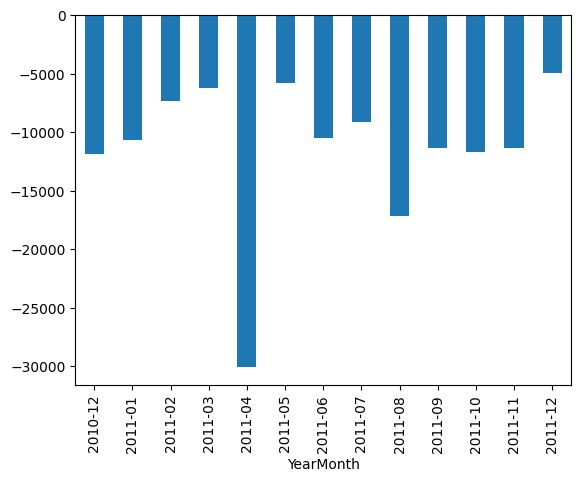

In [276]:
matched_new = matched_sales[(matched_sales["InvoiceDate_cancel"] - matched_sales["InvoiceDate_sale"]) <= np.timedelta64(8, 'D')]
cleaned_data = cancelled_orders[~cancelled_orders["InvoiceNo"].isin(matched_new["InvoiceNo_cancel"])]
cleaned_data.groupby("YearMonth")["TotalPrice"].sum().plot.bar()

### CMO report